In [11]:
strategy_name = '培宏量化1号'
inTime = 240
otTime = 604
tradeArea=[inTime,otTime]
maxD = 4
offStart = ('close_mtx',0)

0 / 1079 960 2018-01-03 01:31:00 2018-01-08 07:00:00
100 / 1079 960 2018-04-10 01:31:00 2018-04-13 07:00:00
200 / 1079 960 2018-07-12 01:31:00 2018-07-17 07:00:00
300 / 1079 960 2018-10-31 01:31:00 2018-11-05 07:00:00
400 / 1079 960 2019-02-01 01:31:00 2019-02-13 07:00:00
500 / 1079 960 2019-04-04 01:31:00 2019-04-10 07:00:00
600 / 1079 960 2019-07-22 01:31:00 2019-07-25 07:00:00
700 / 1079 960 2019-10-28 01:31:00 2019-10-31 07:00:00
800 / 1079 960 2020-02-17 01:31:00 2020-02-20 07:00:00
900 / 1079 960 2020-04-30 01:31:00 2020-05-08 07:00:00
1000 / 1079 960 2020-07-27 01:31:00 2020-07-30 07:00:00
['净利润增速连续三年大于20%', '季度净利润连续三年大于1亿', '跳空高开', '突破1年新高(开盘)', '突破3个月新高(开盘)', '均线多头排列', 'MACD高于DEA', 'MACD大于0', '交易量放大2倍', '流通市值大于100亿', '流通市值大于250亿', '流通市值大于500亿', '流通市值小于100亿', '流通市值小于50亿', '流通市值小于25亿']
盈利前10%交易 净利润增速连续三年大于20% 12.04 294333.0
盈利前10%交易 季度净利润连续三年大于1亿 32.41 687924.0
盈利前10%交易 跳空高开 99.07 287679.0
盈利前10%交易 突破1年新高(开盘) 1.85 107147
盈利前10%交易 突破3个月新高(开盘) 19.44 163629
盈利前10%交易 均线多头排列 70.37 32

C:\Users\xudong\Documents\github\coresearch\funcs\rschLib.py:186: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
C:\Users\xudong\Documents\github\coresearch\funcs\rschLib.py:186: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
C:\Users\xudong\Documents\github\coresearch\funcs\rschLib.py:186: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the r

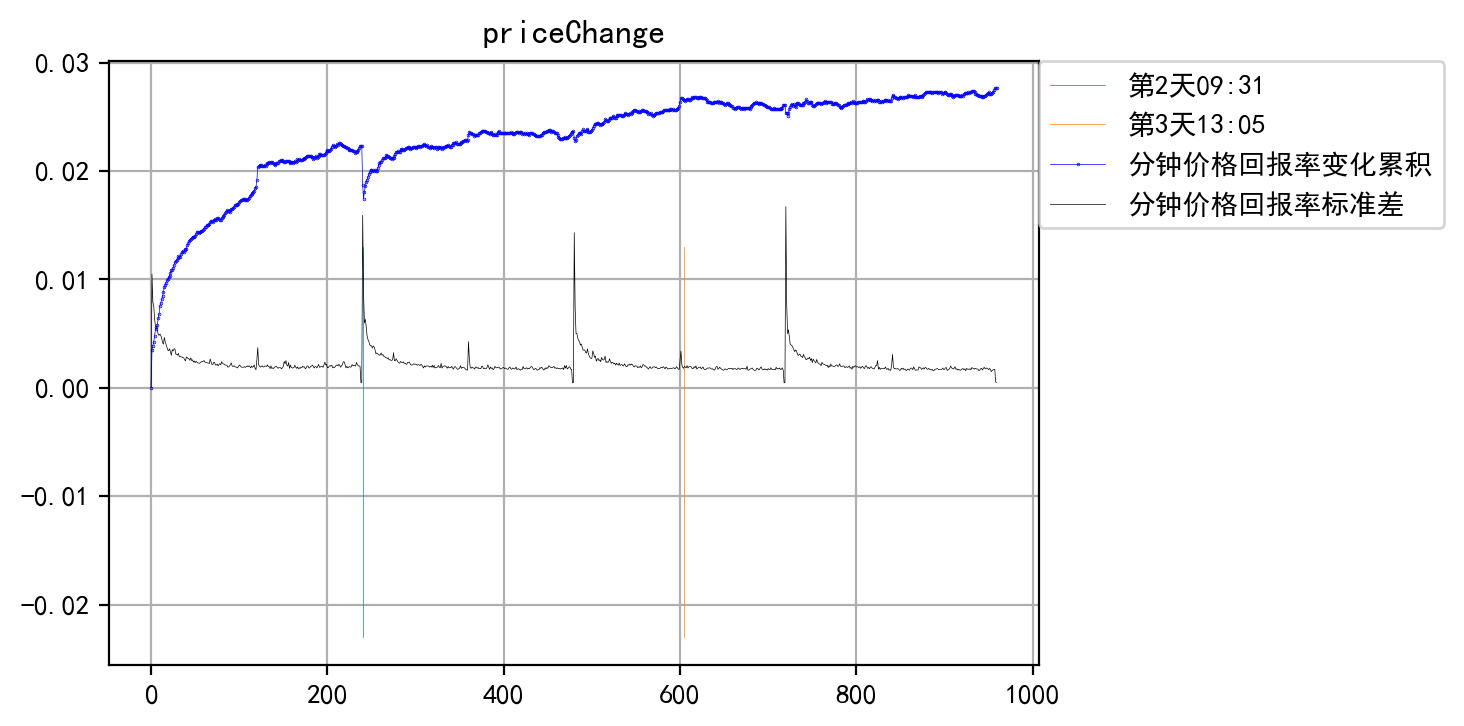

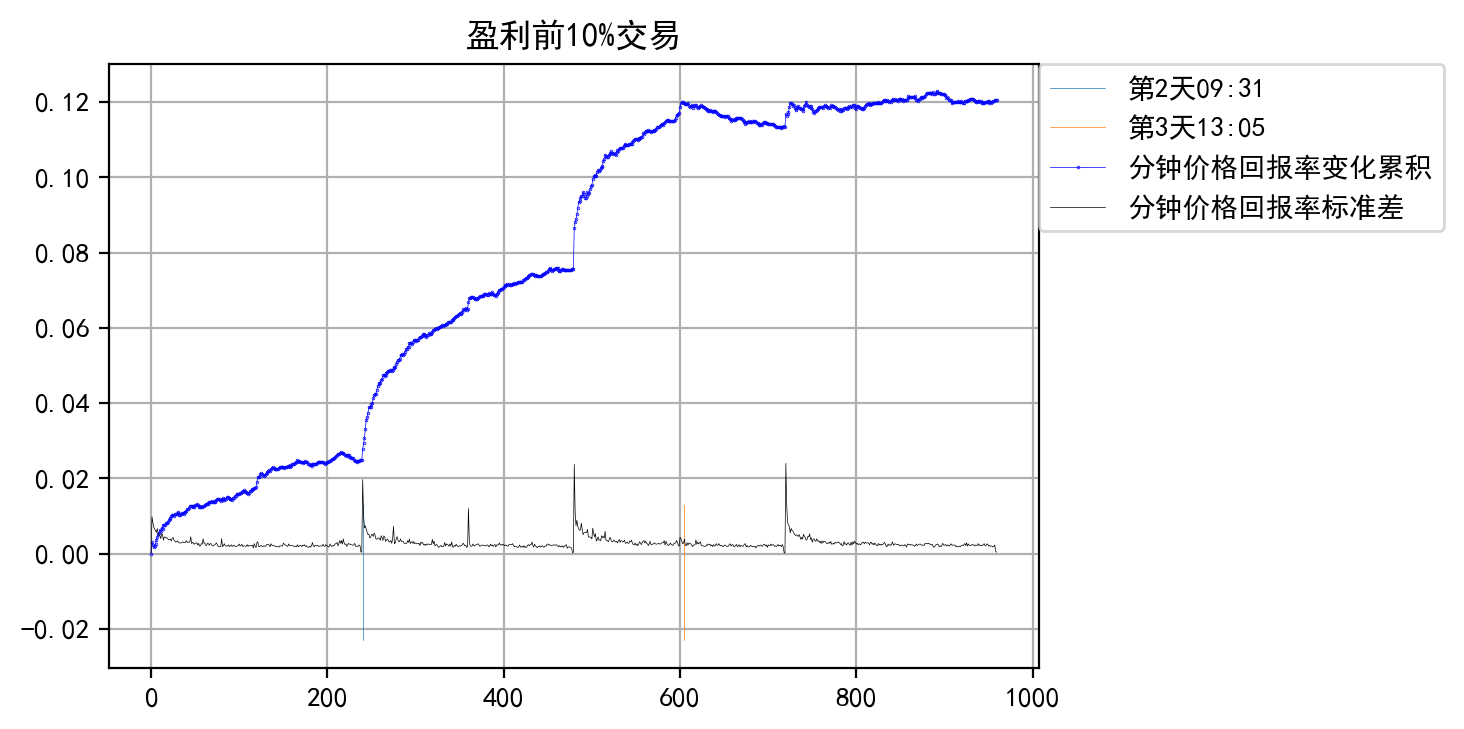

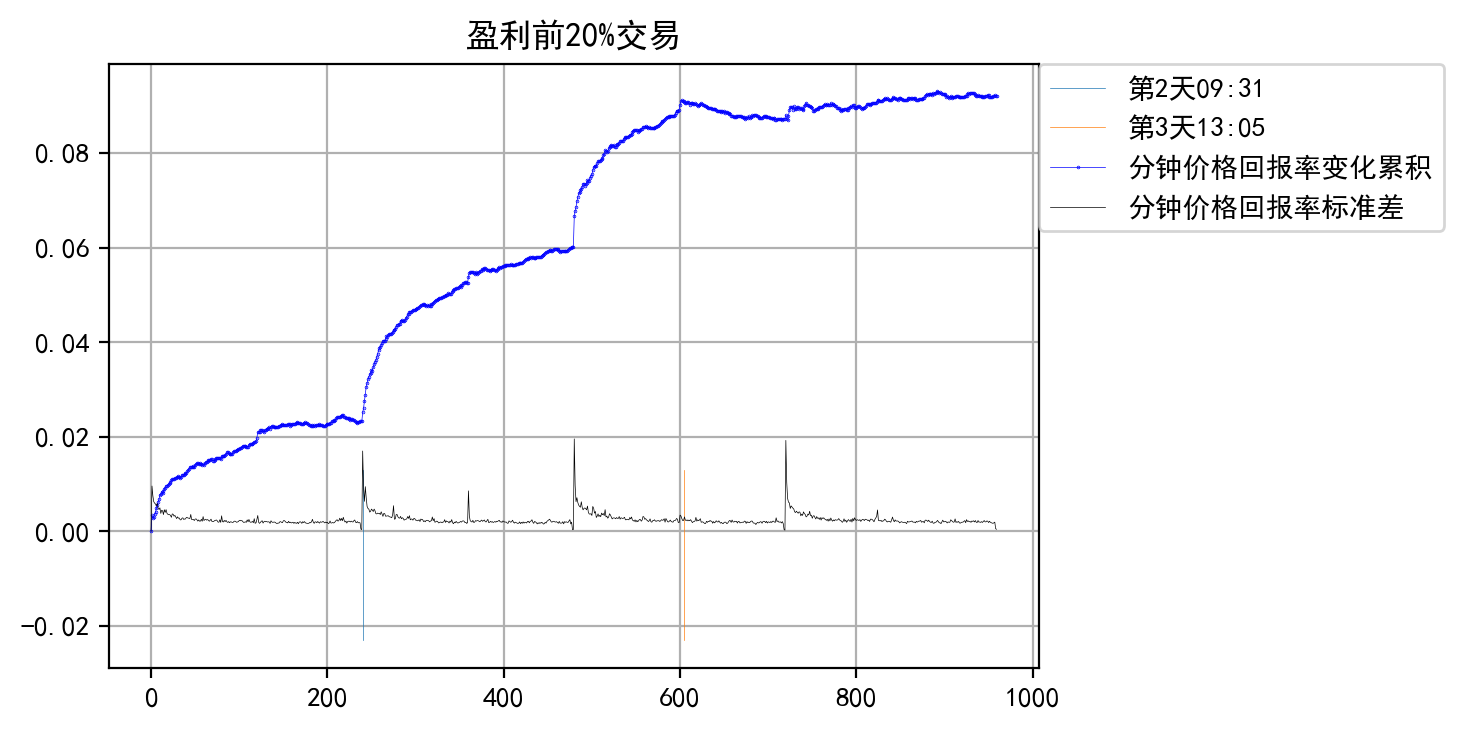

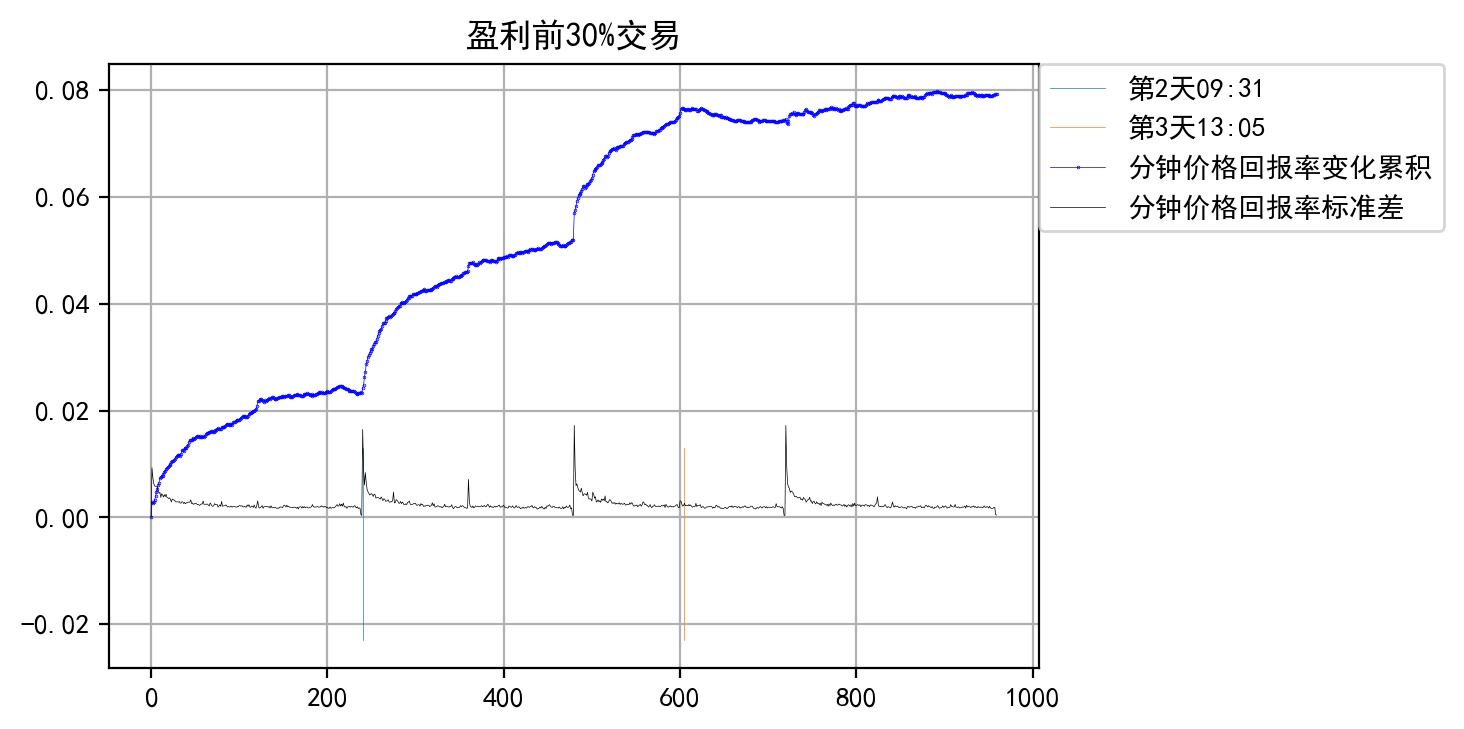

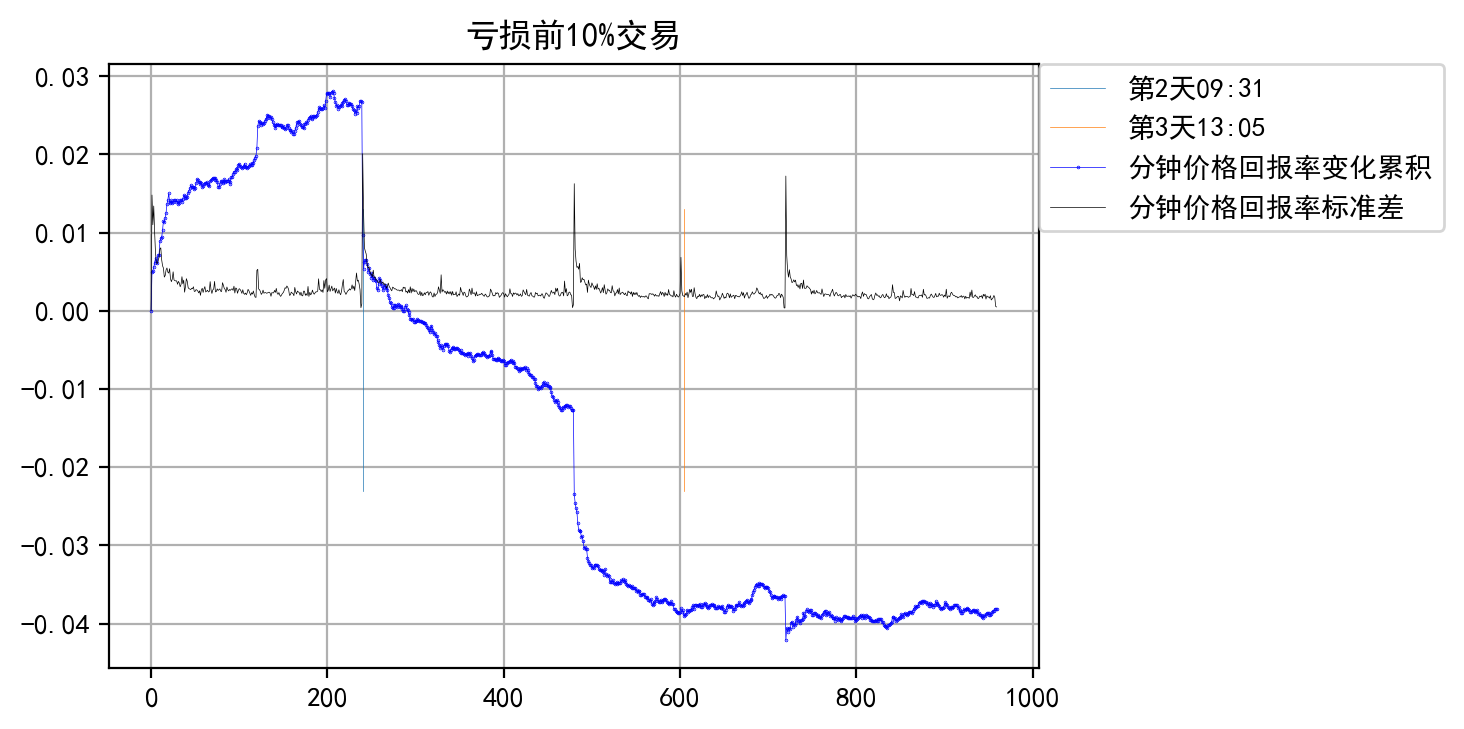

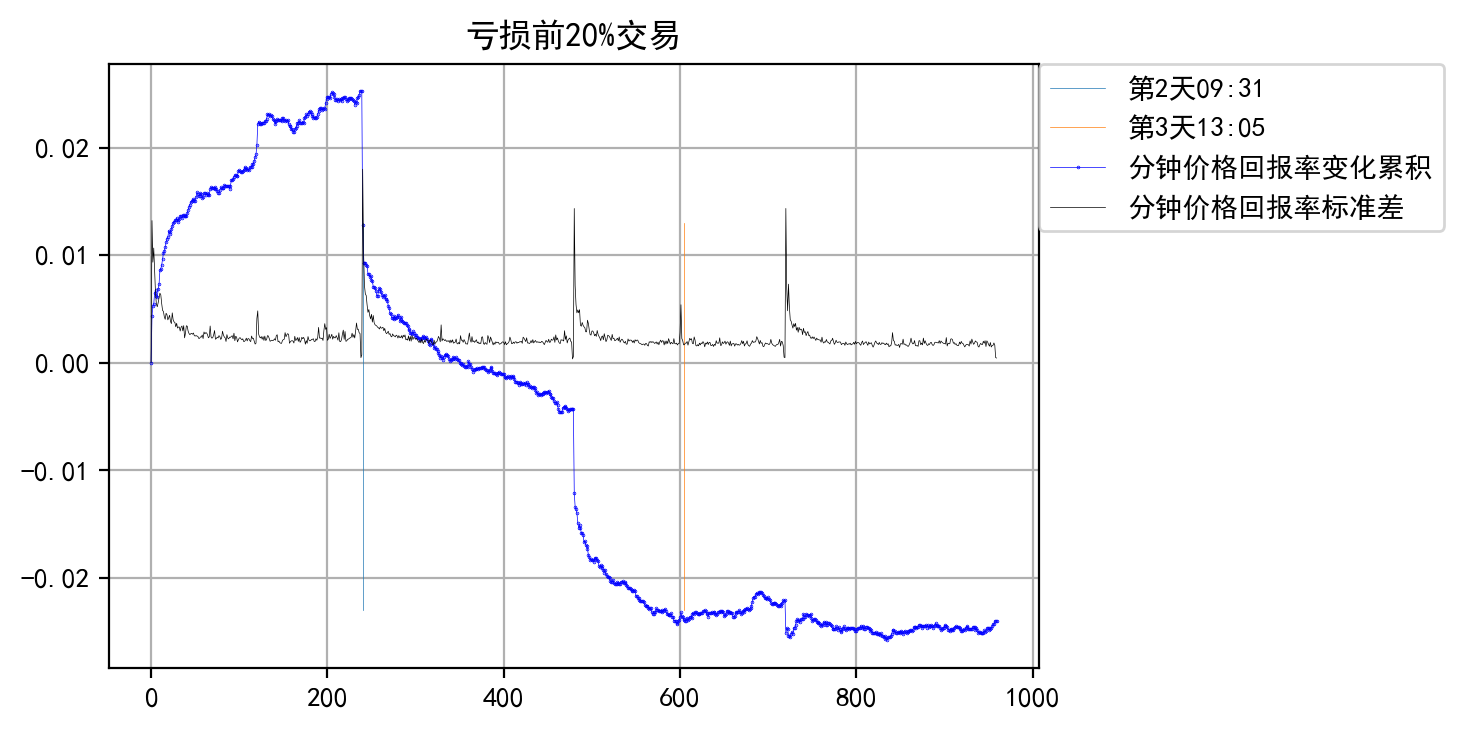

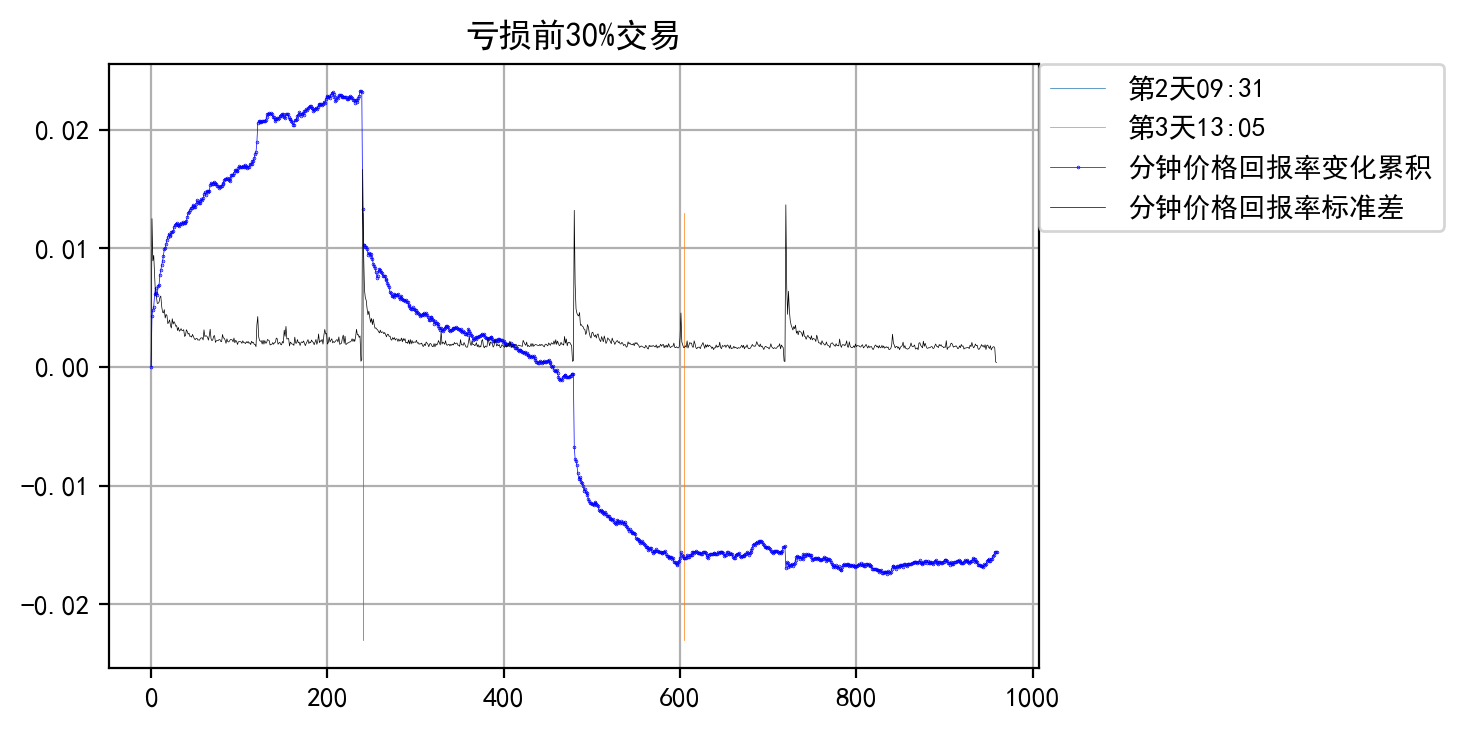

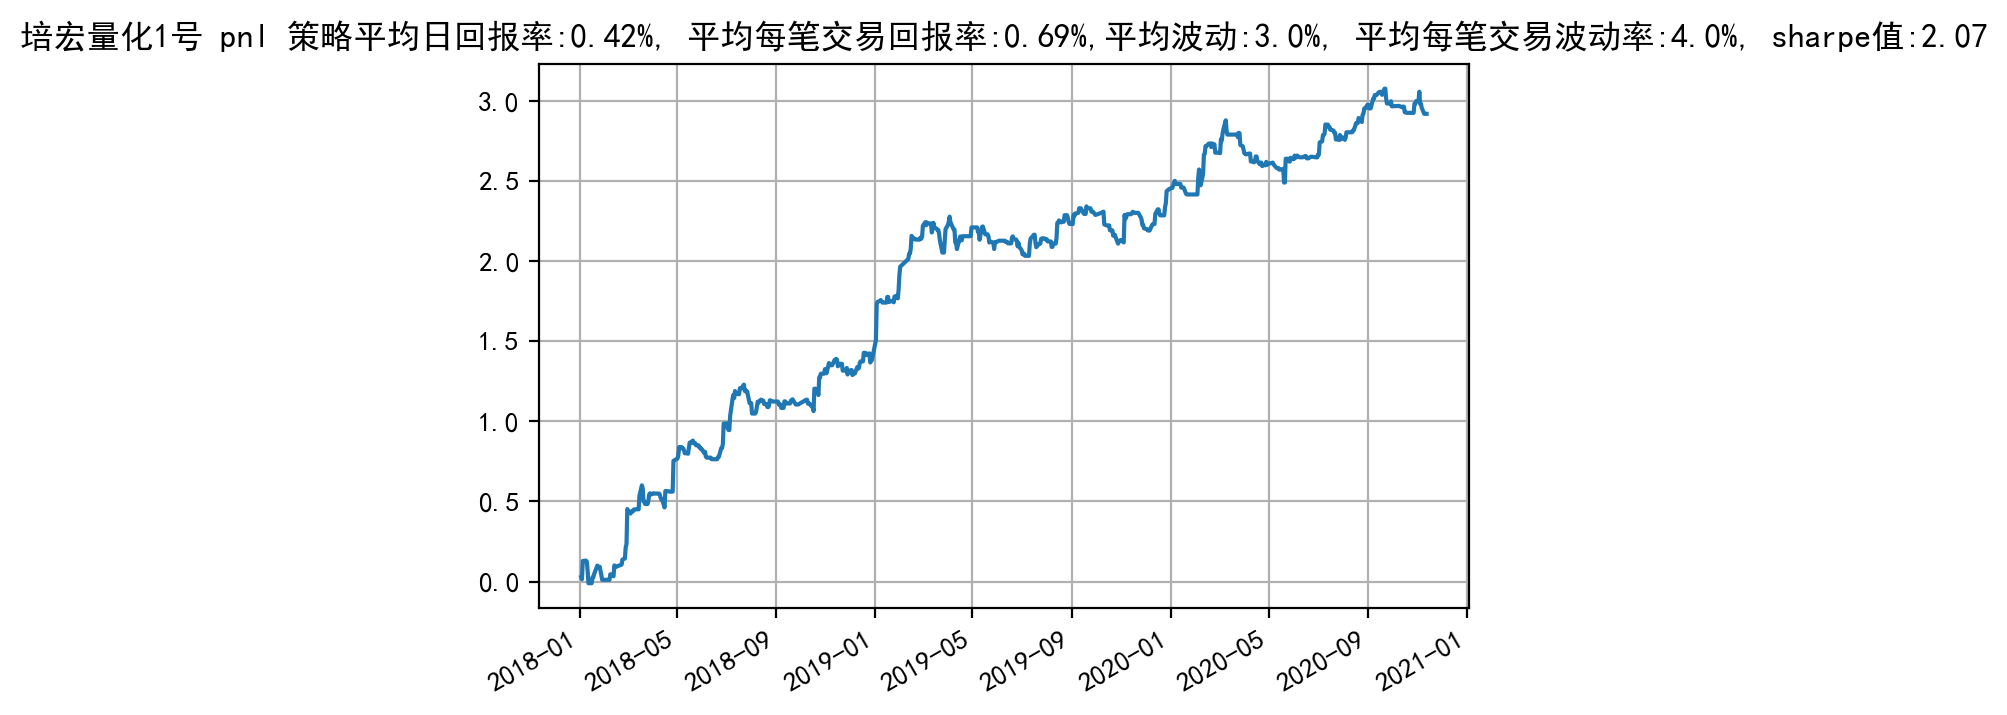

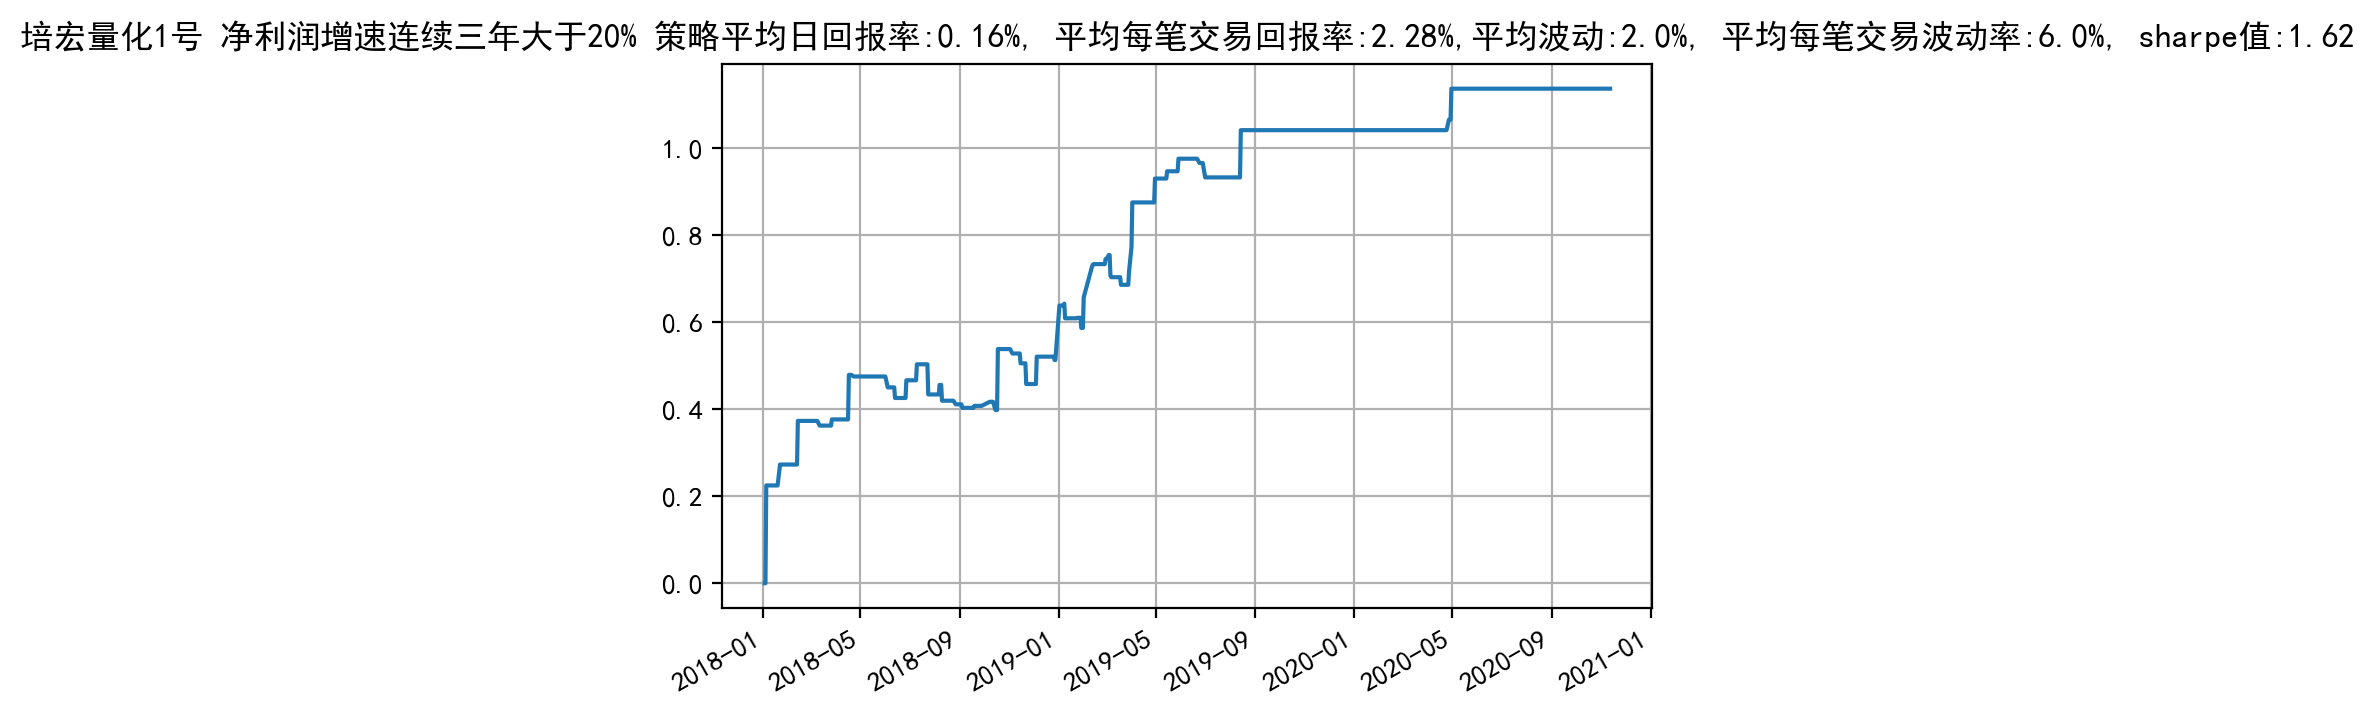

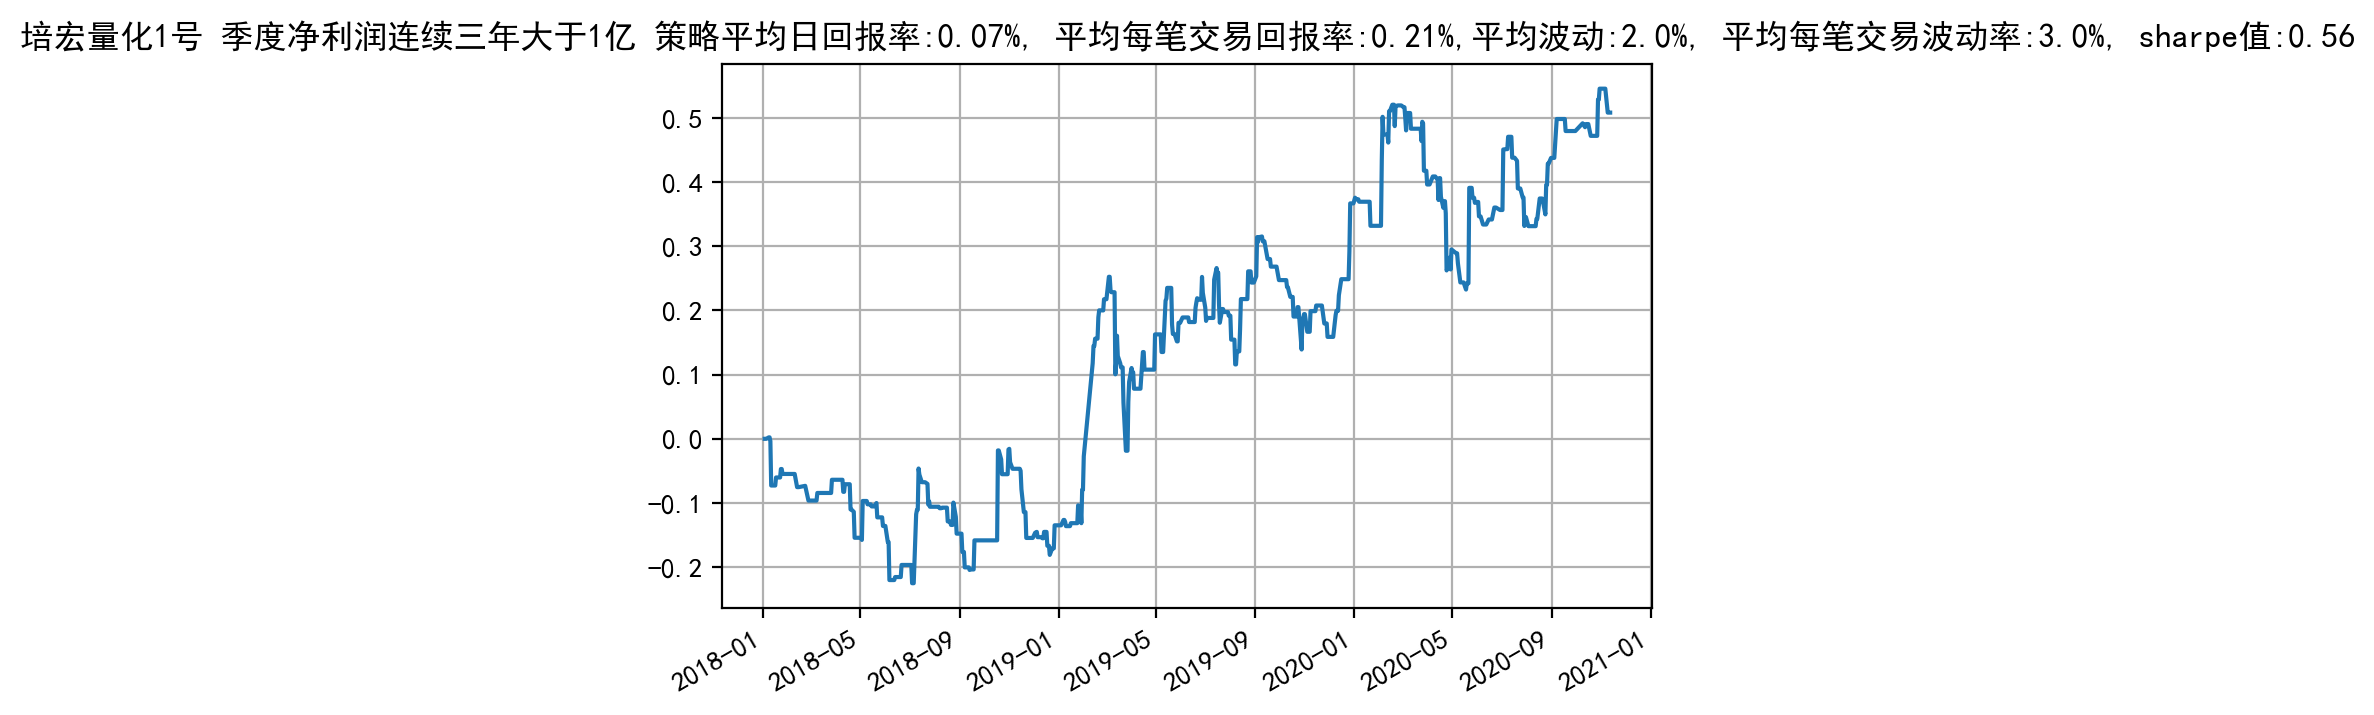

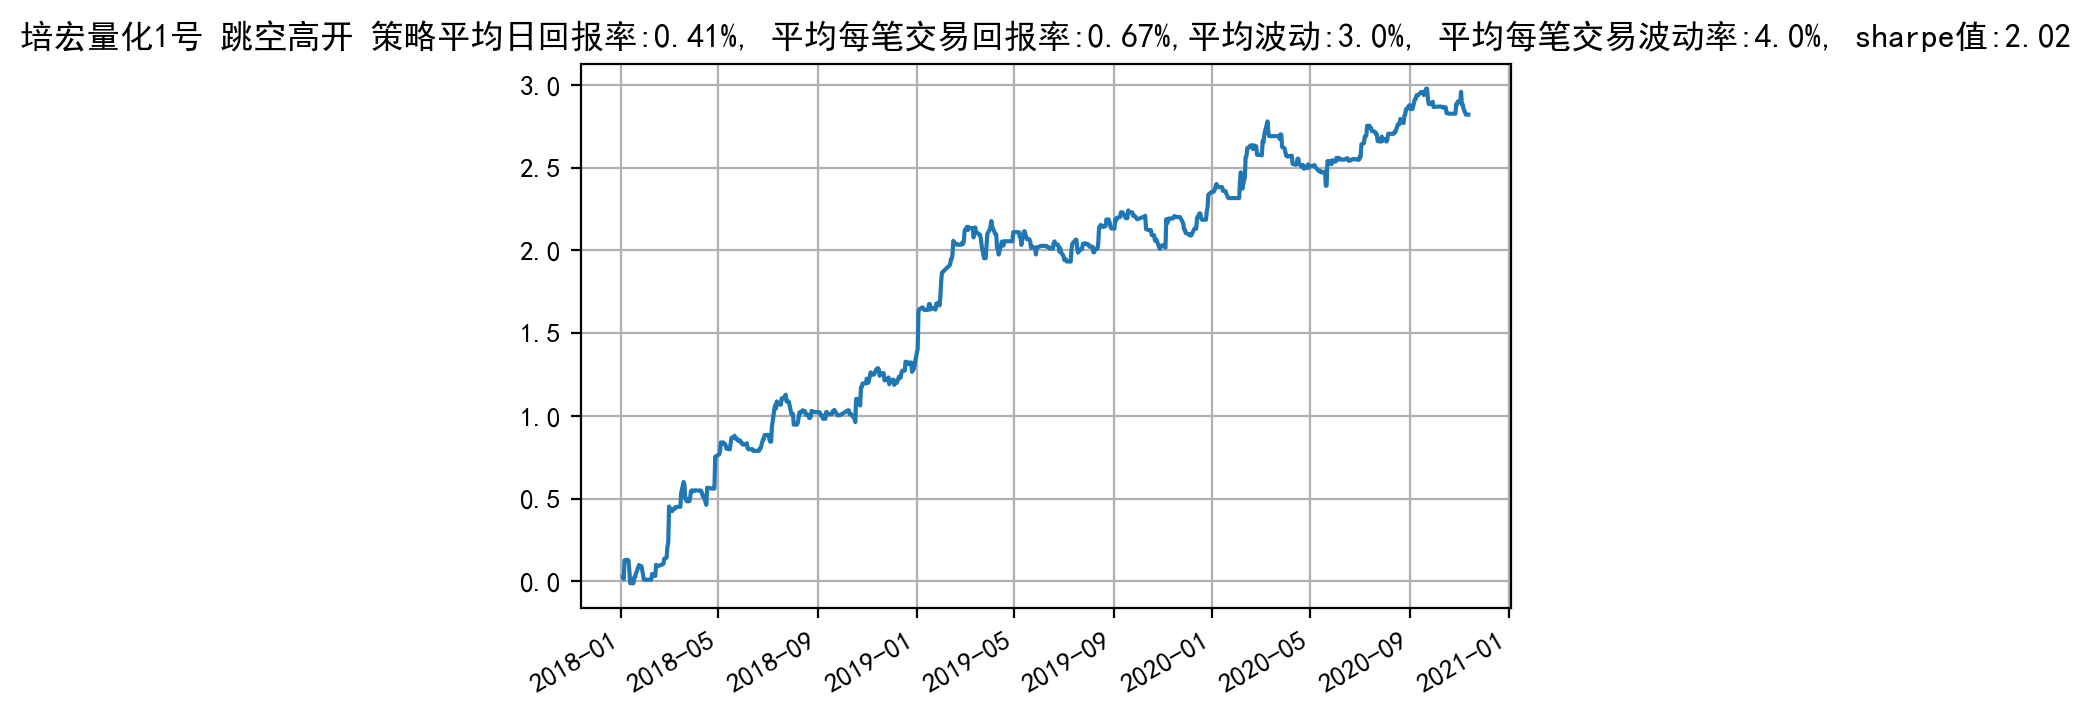

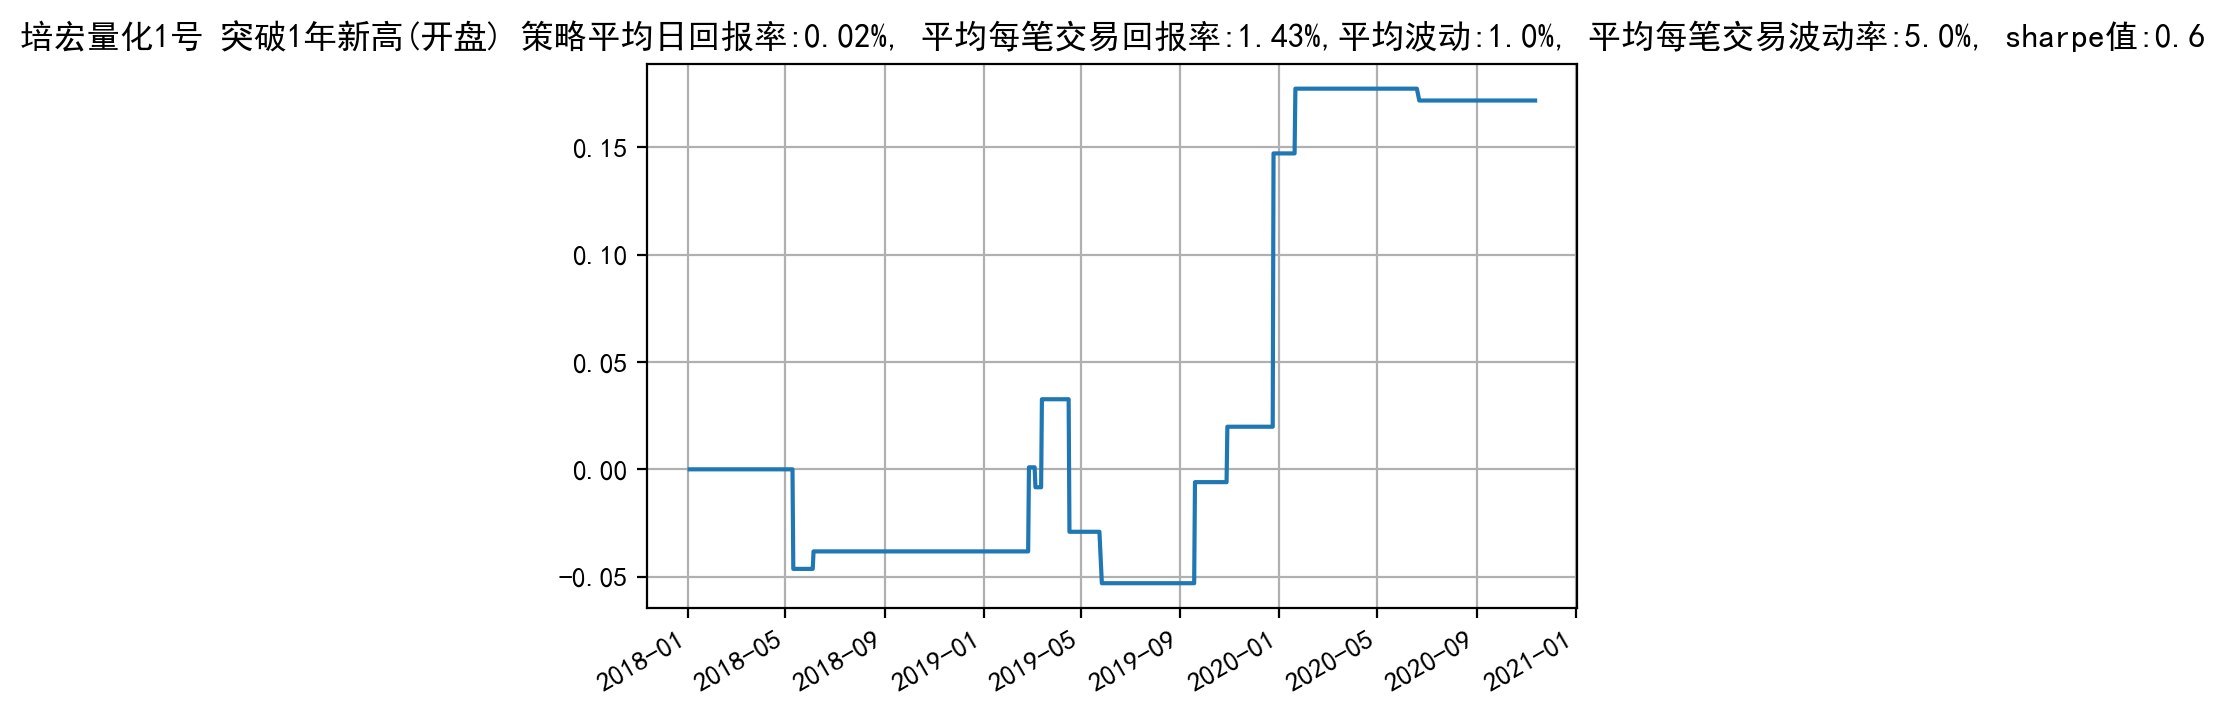

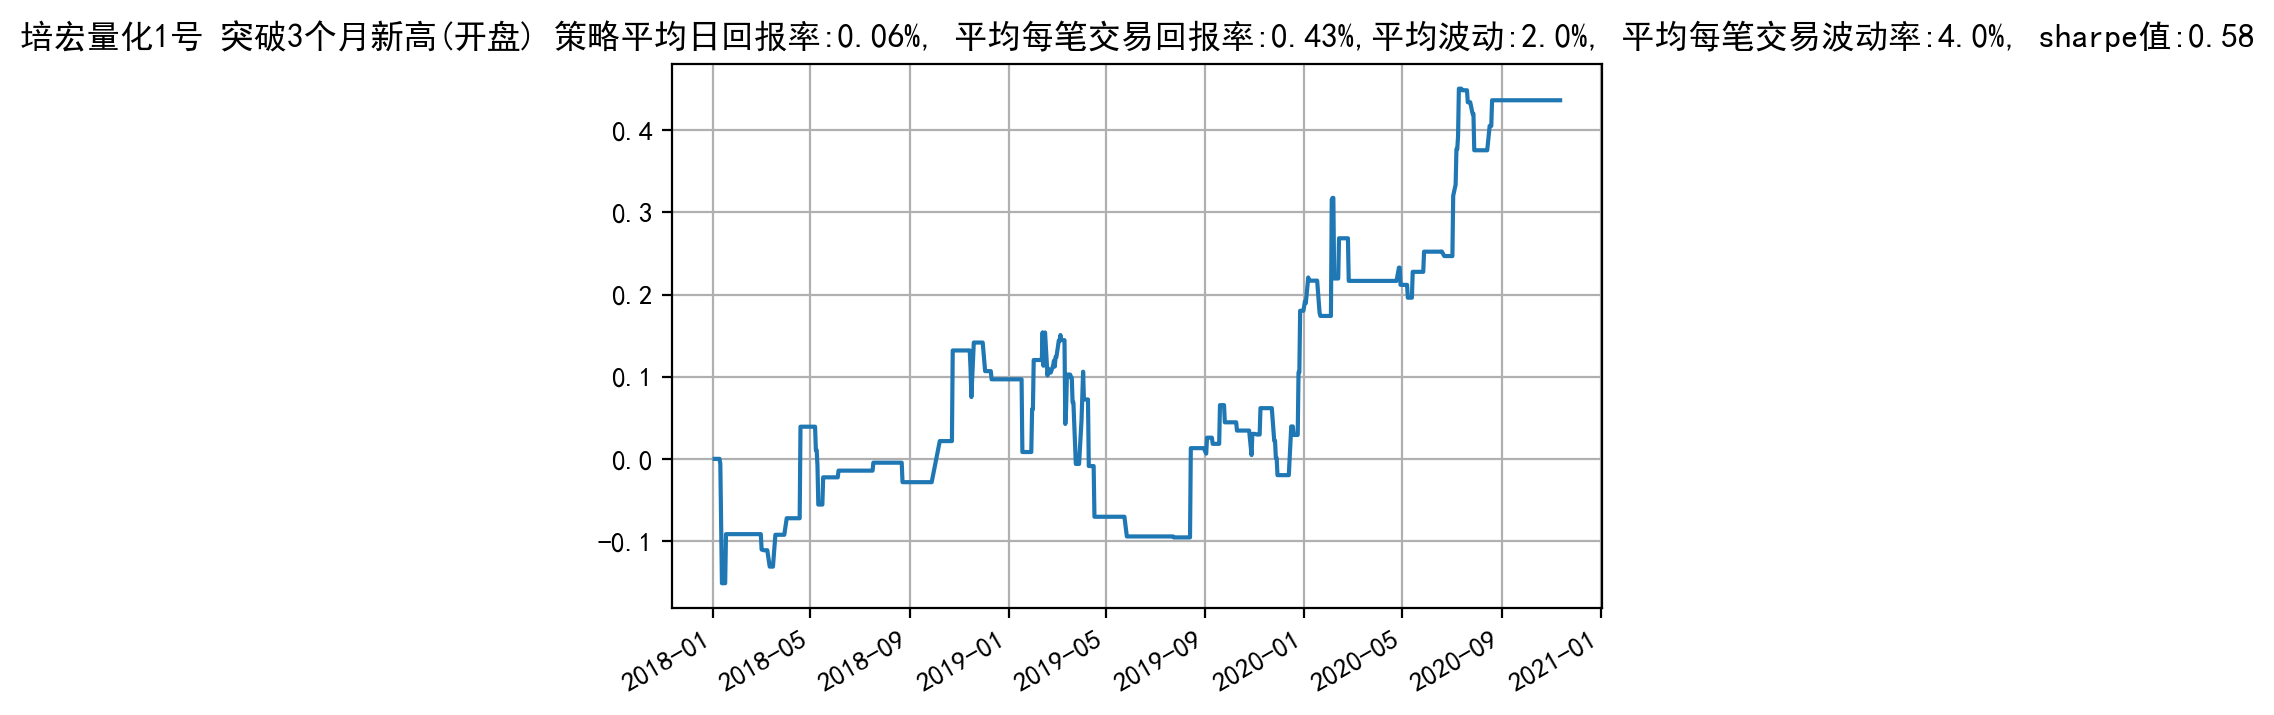

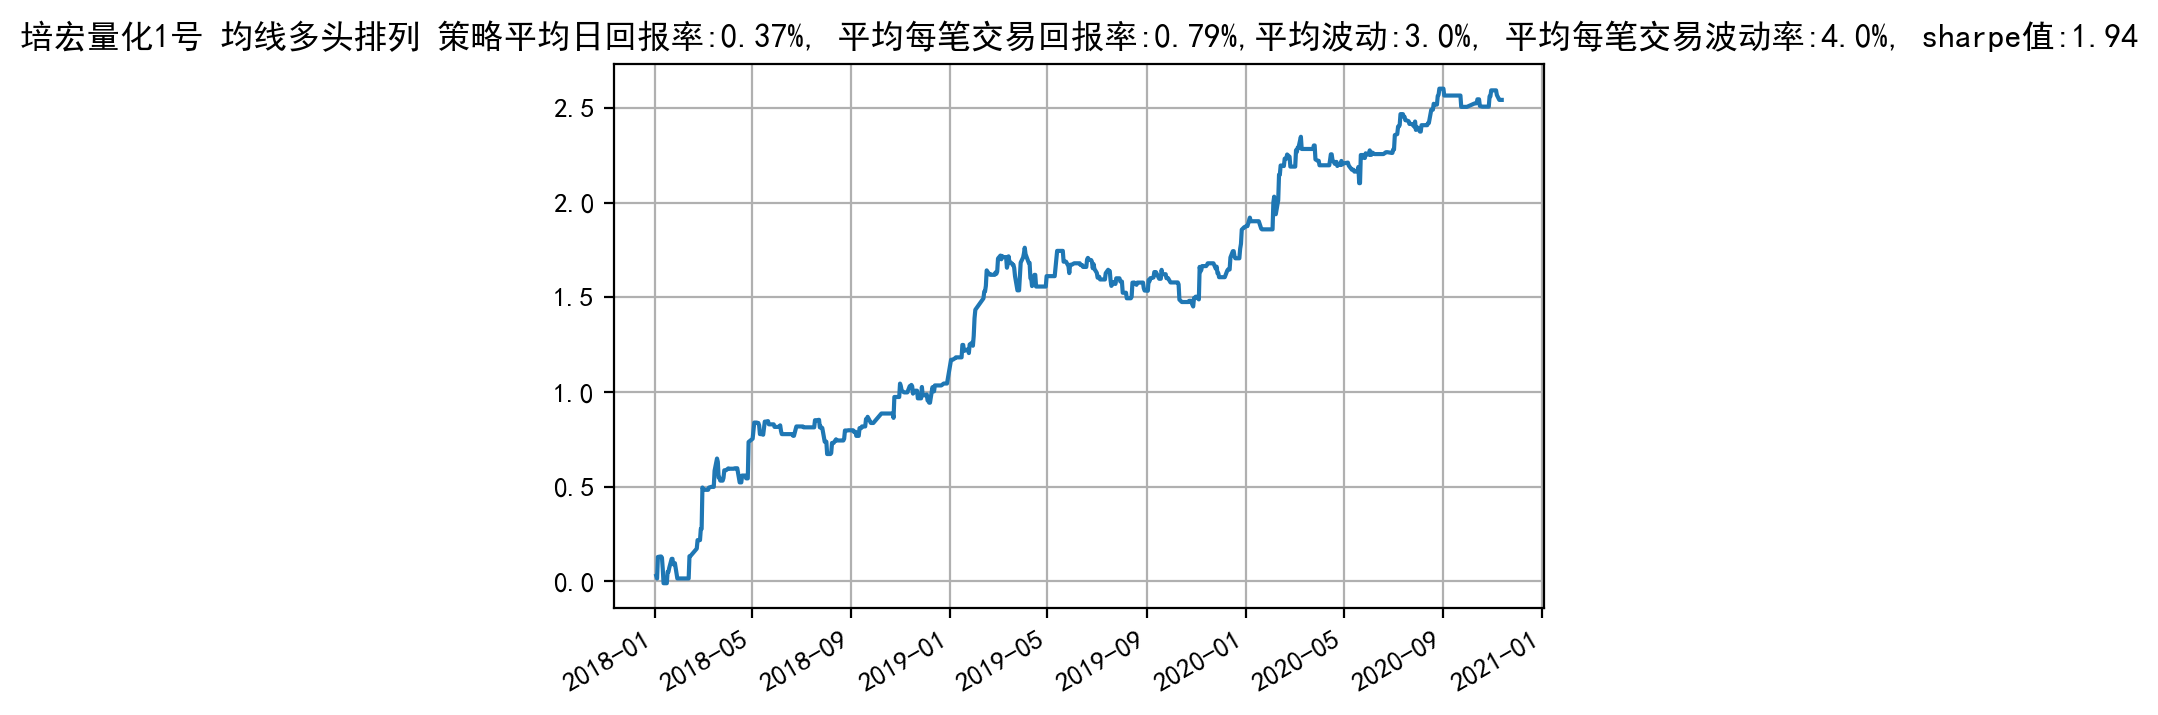

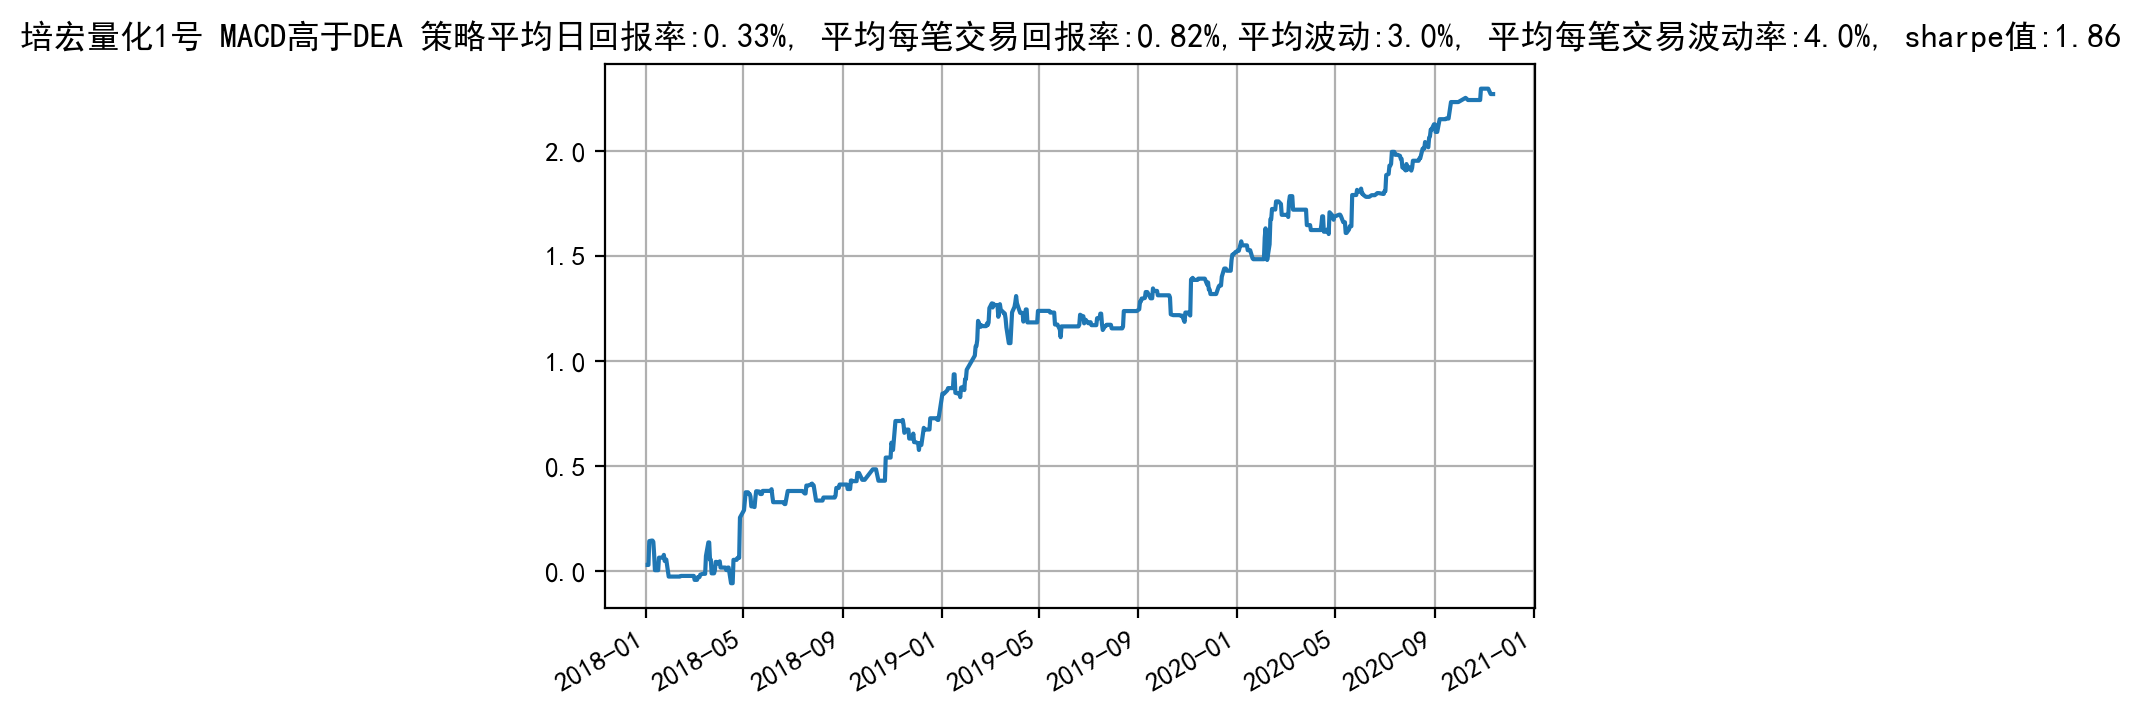

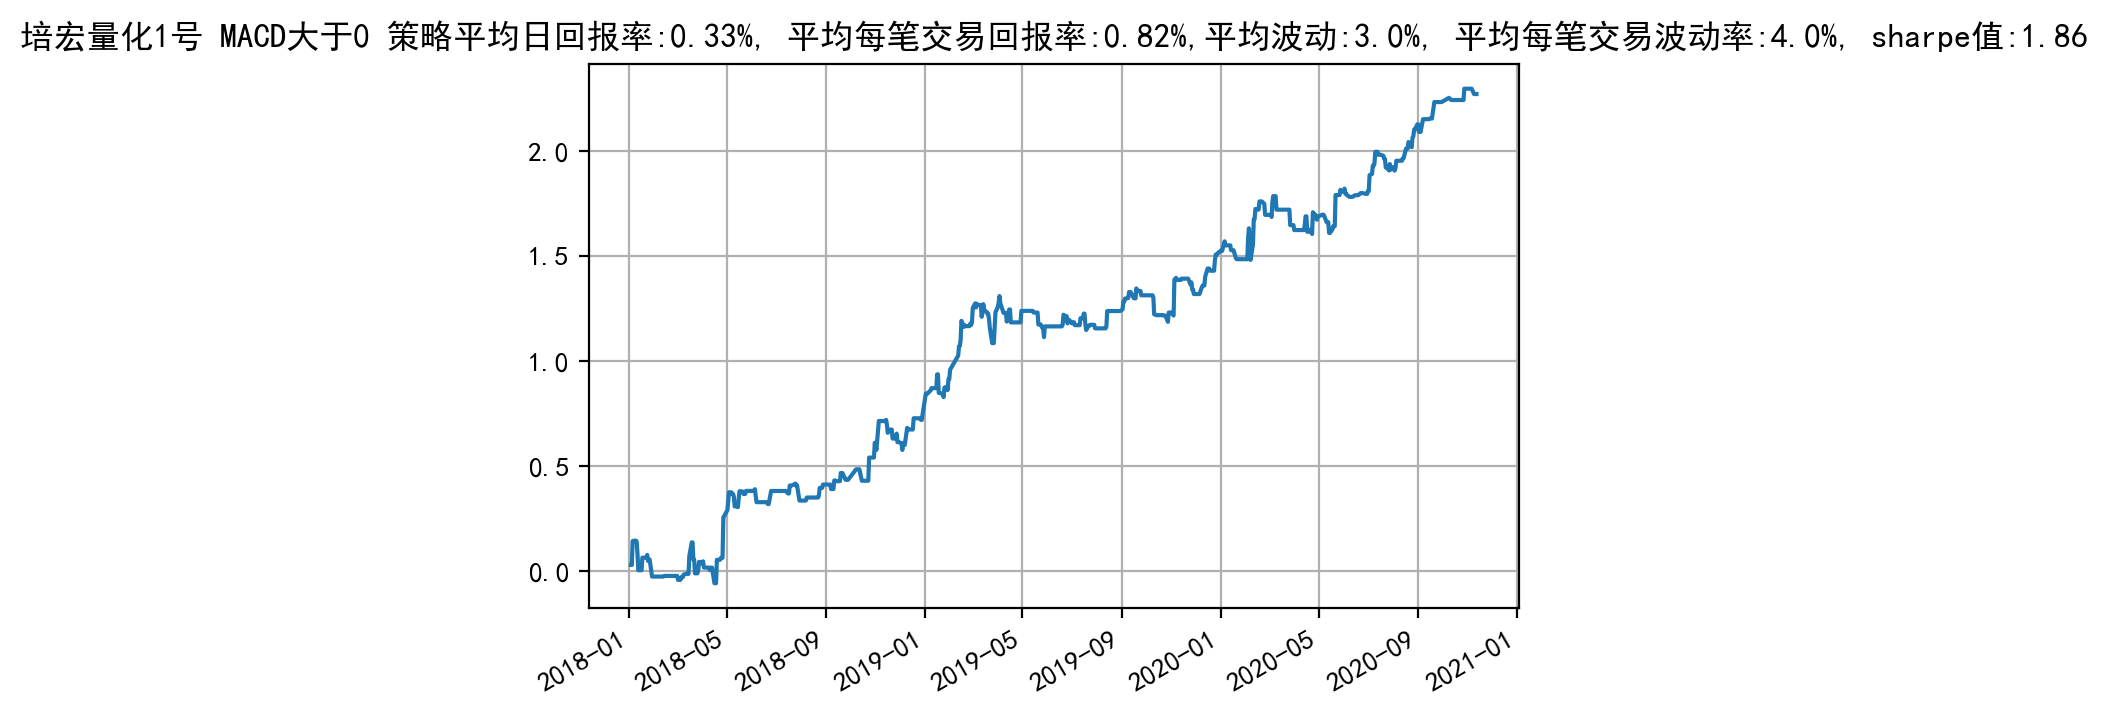

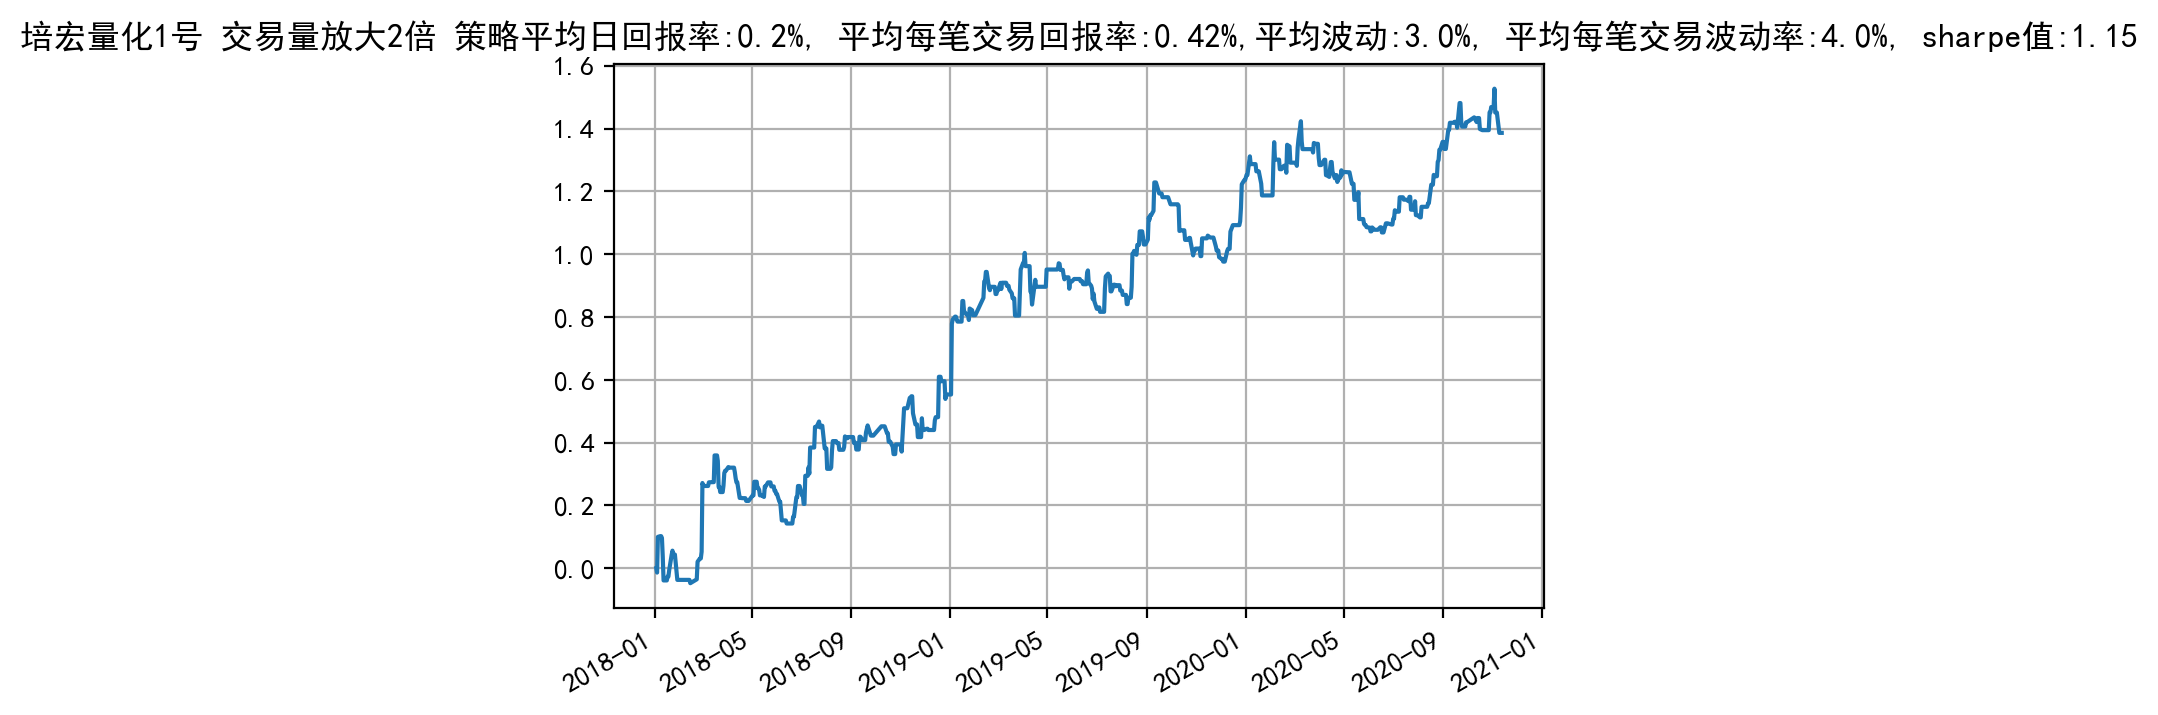

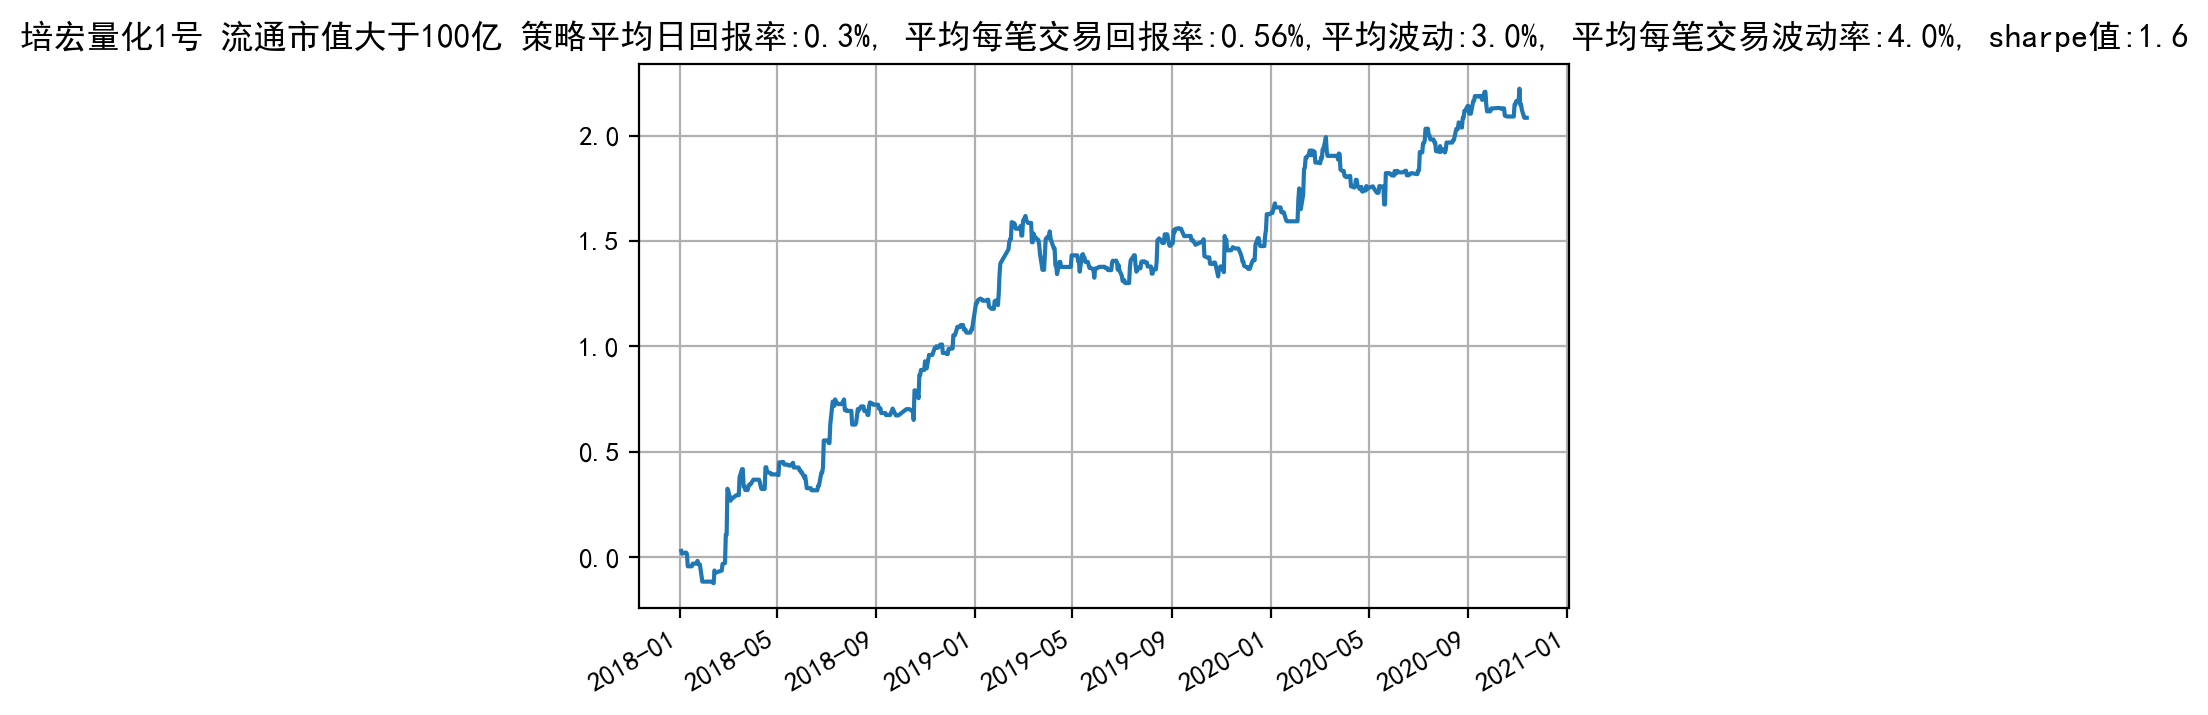

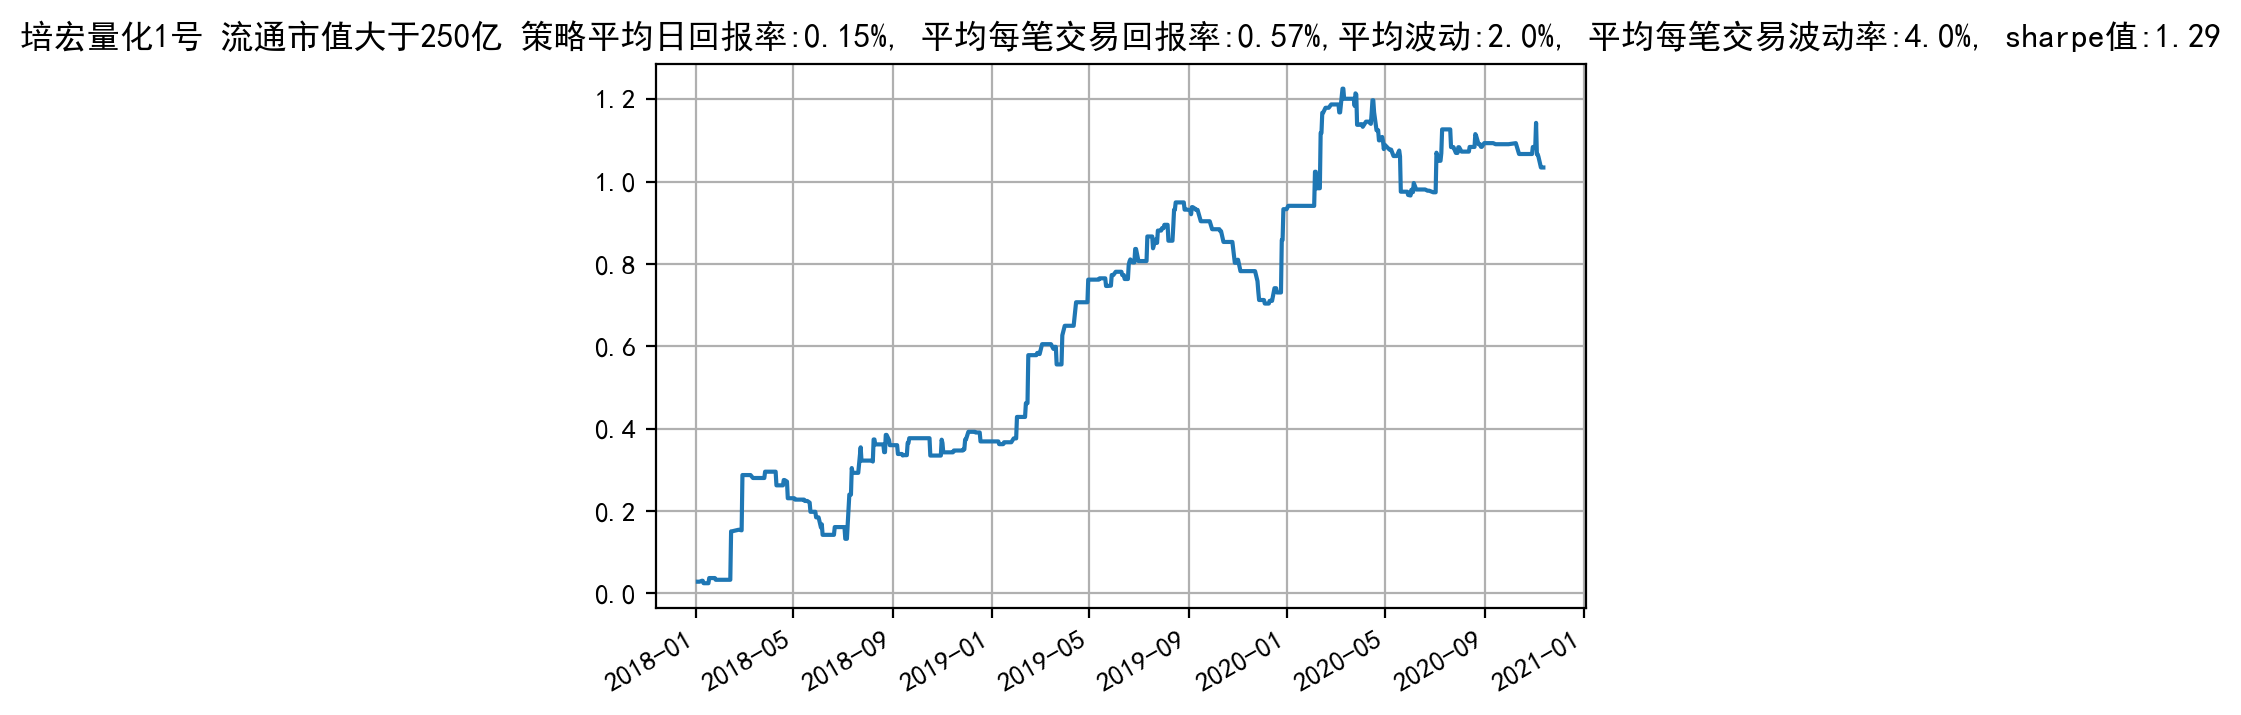

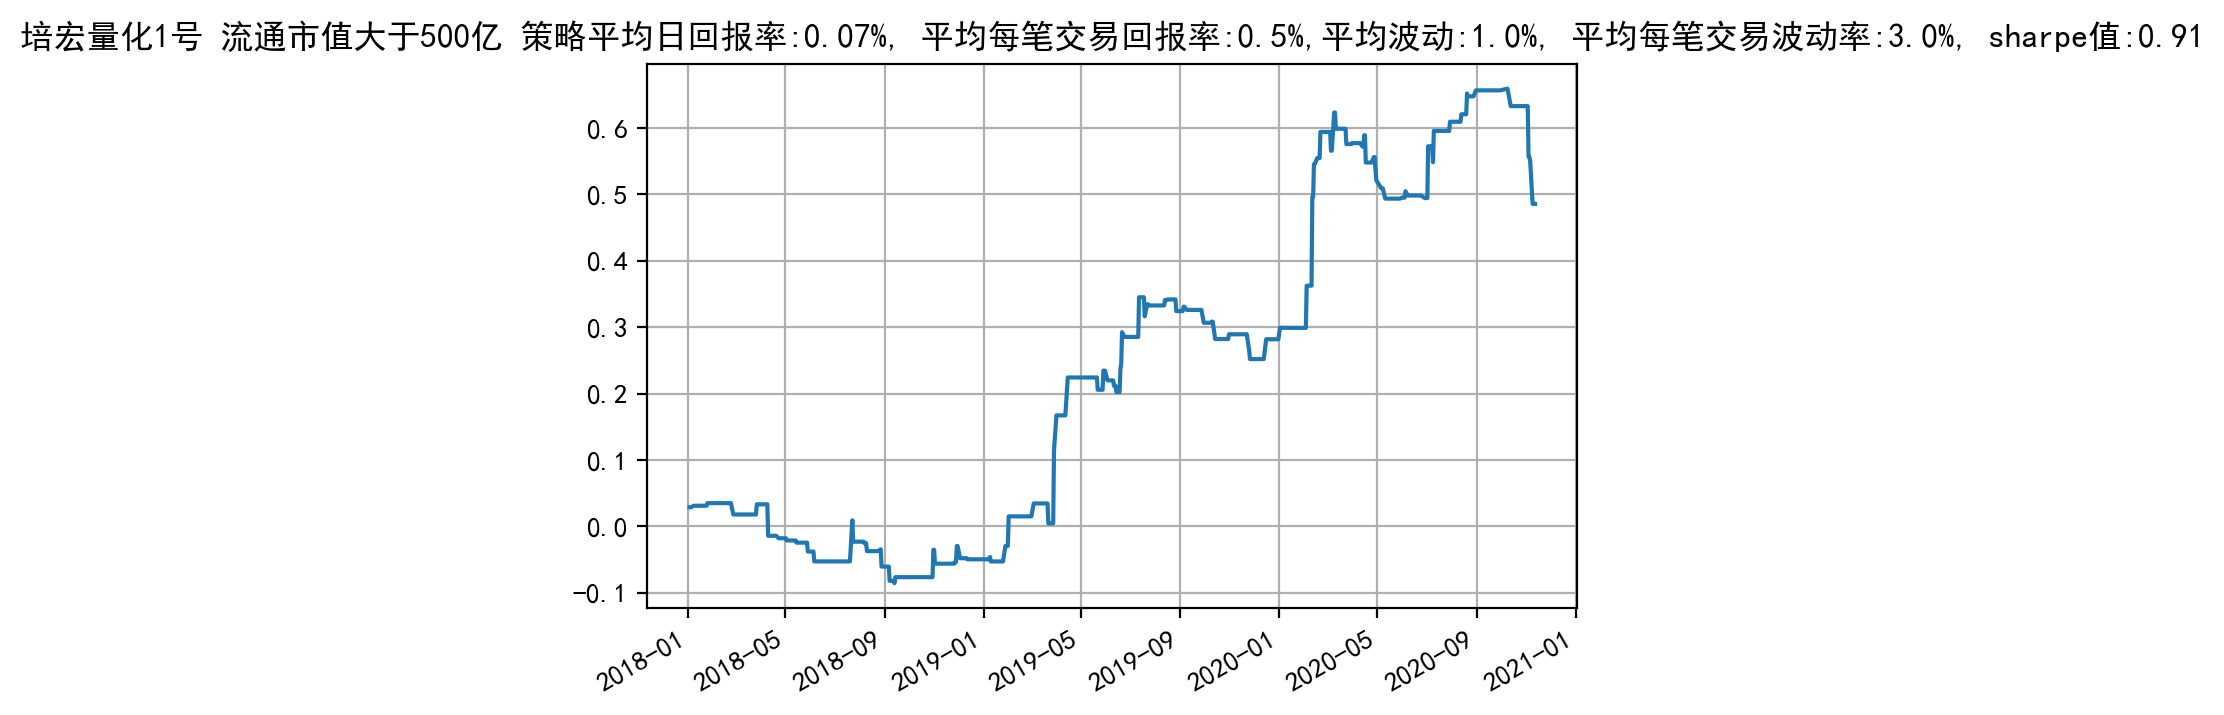

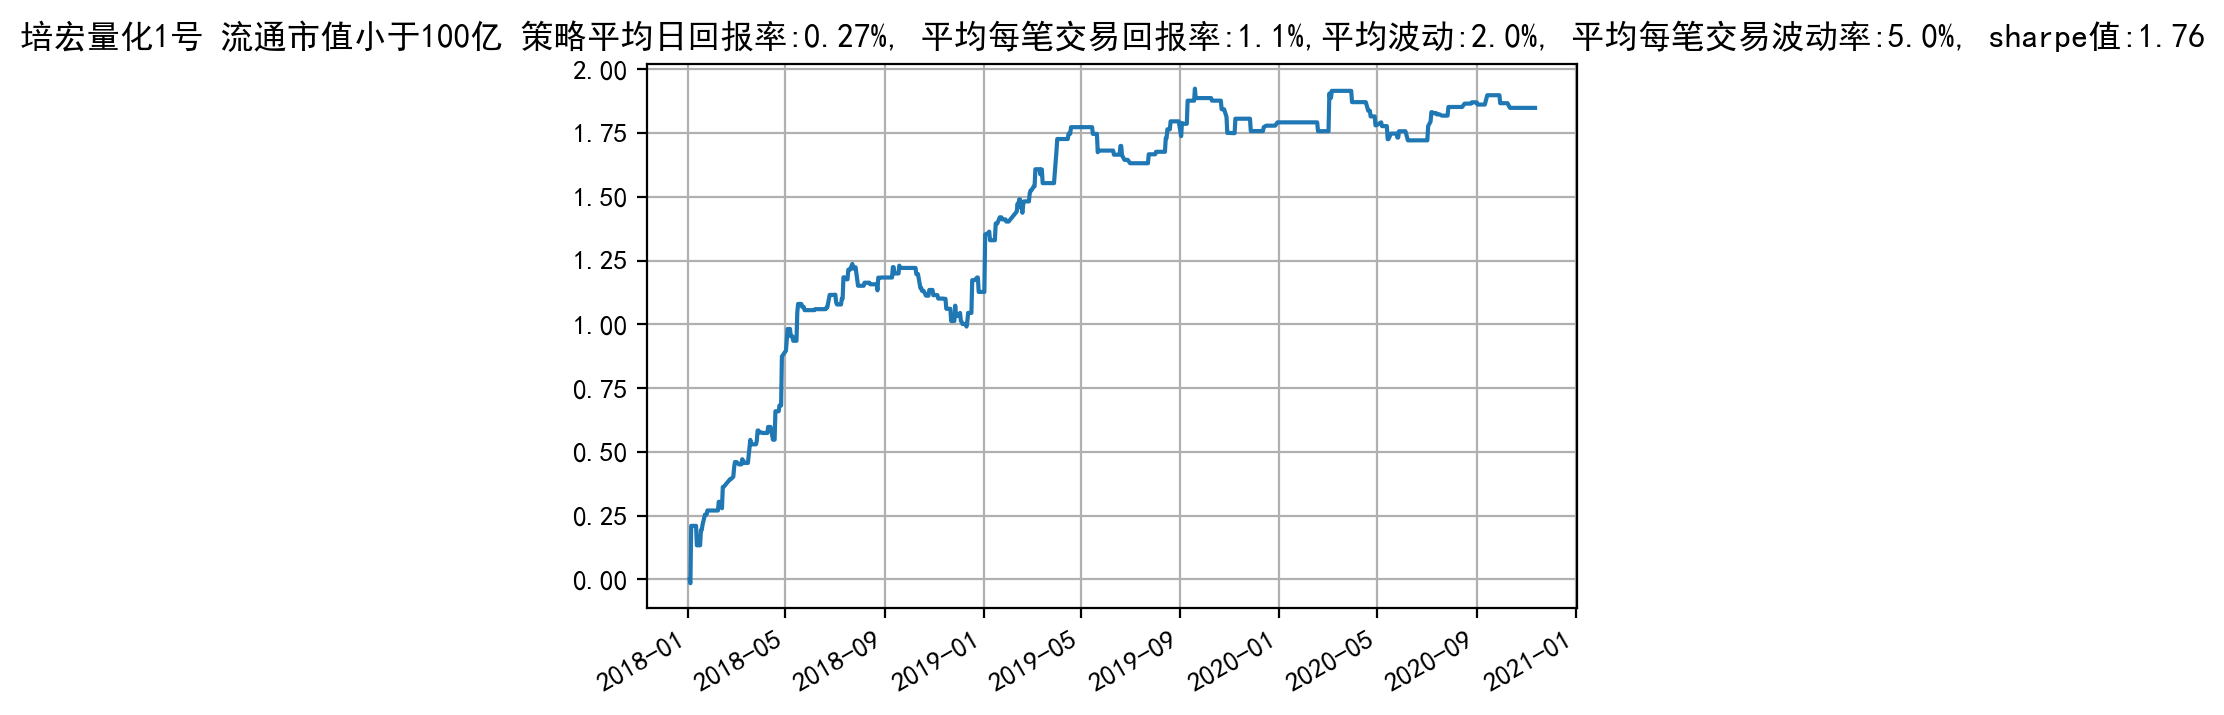

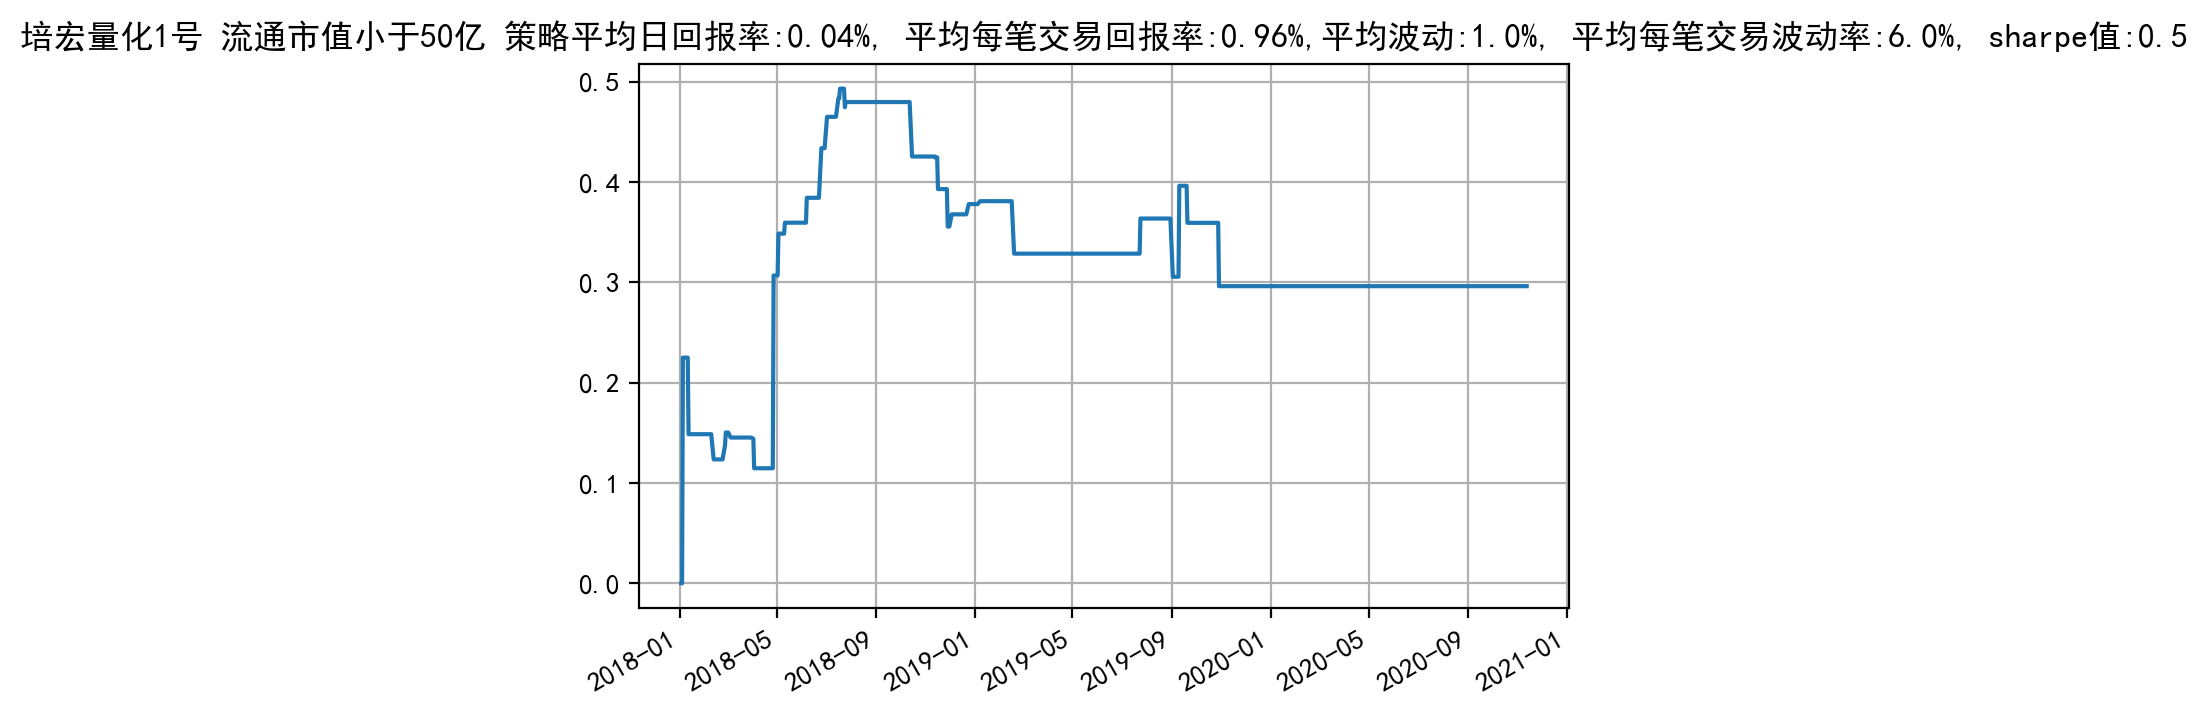

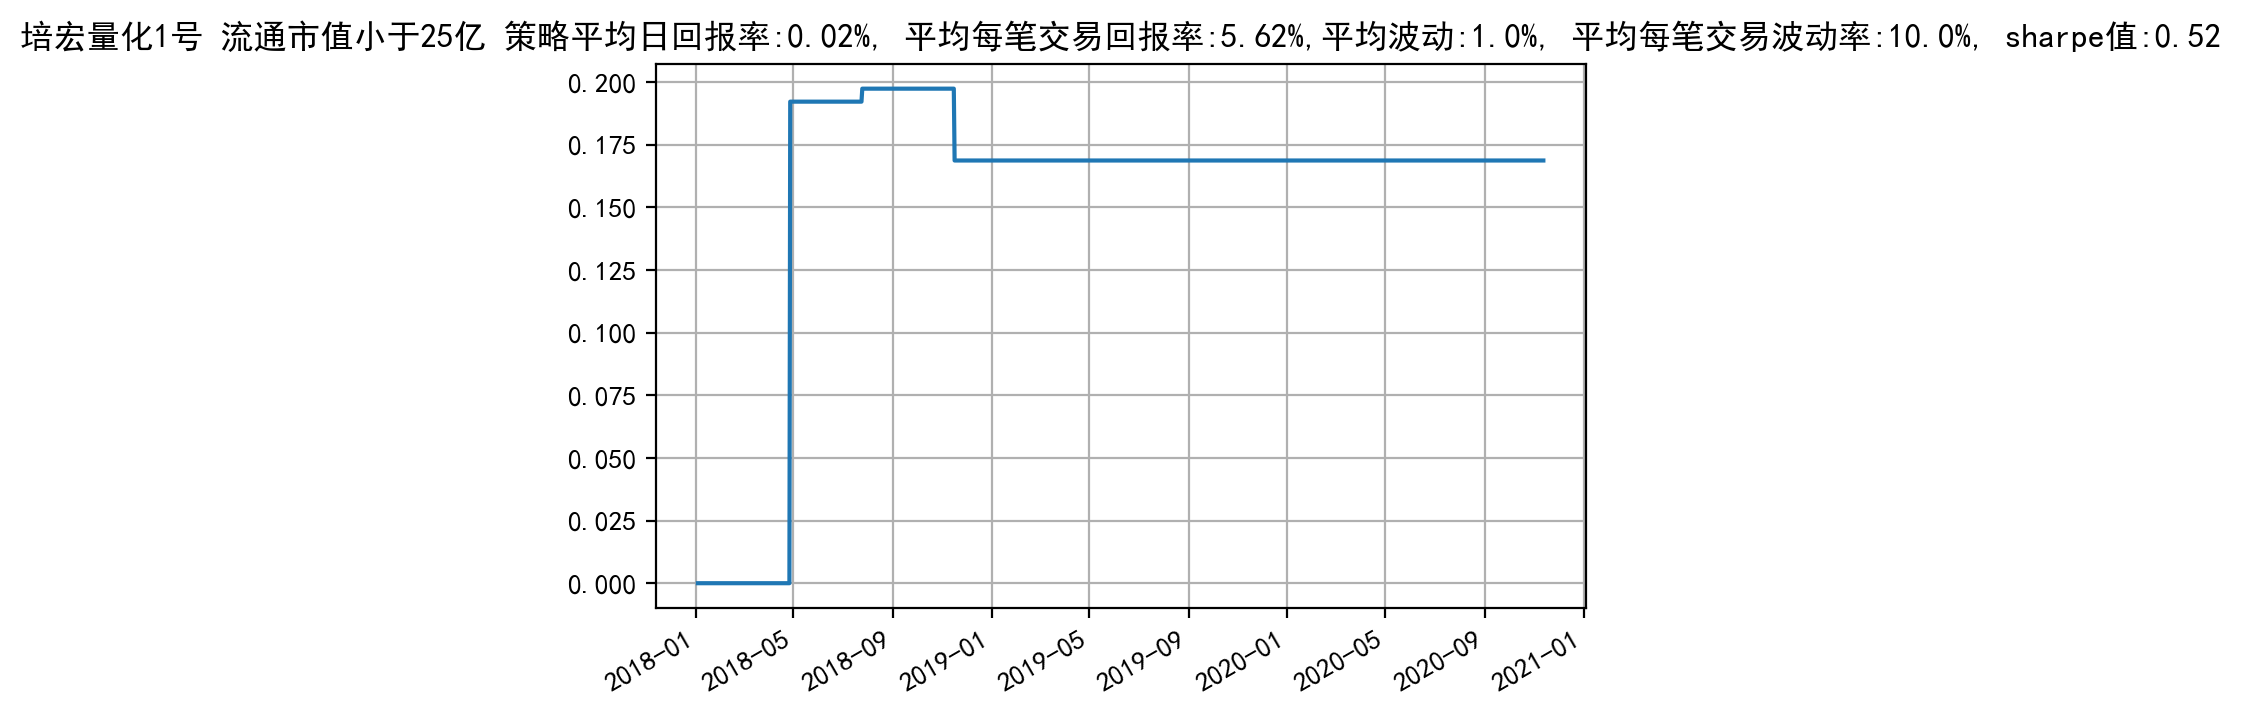

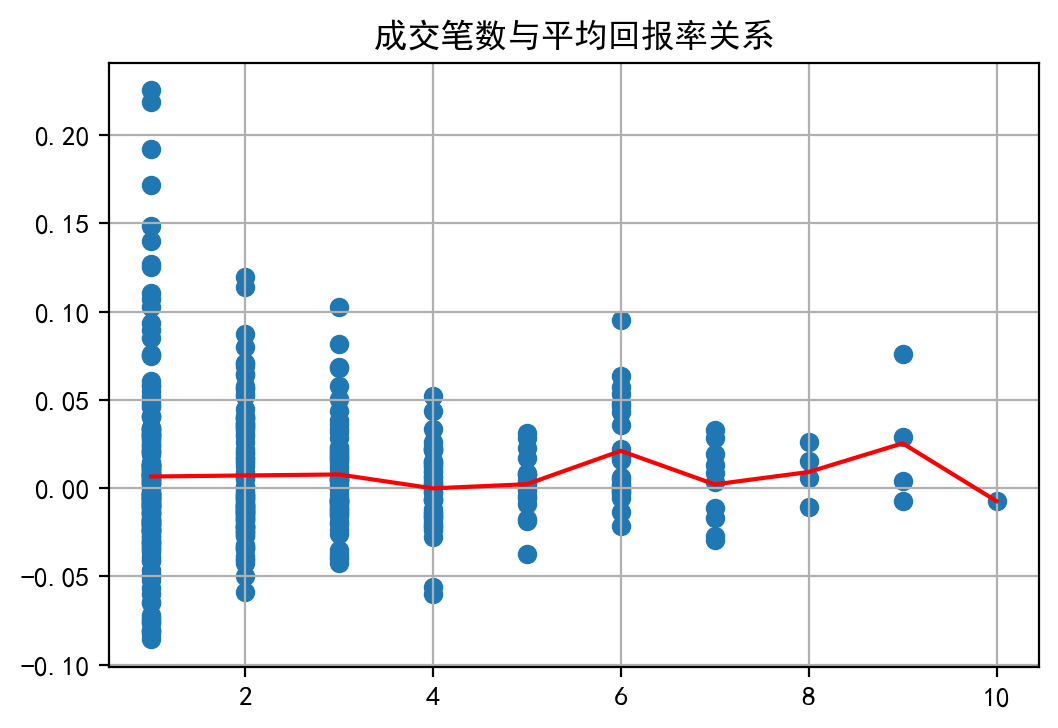

In [12]:
import sys
sys.path.append("C:\Program Files\Tinysoft\Analyse.NET")
sys.path.append(r"C:\Users\xudong\Documents\github\coresearch\funcs")
import pymongo
import numpy as np
import pickle
import time
import datetime
import copy
import pandas as pd
from operator import itemgetter
import TSLPy3 as tsl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import talib
import importlib
import rschLib
np.set_printoptions(formatter={'float_kind': "{:.6f}".format})
client = pymongo.MongoClient('localhost', 27017)
db = client.quanLiang
dbt = client.tinySoftData
dtes, tkrs, name, open_mtx, high_mtx, low_mtx, close_mtx,belong, shenwan1, shenwan2, shenwan3, vol_mtx, amount_mtx = rschLib.loadDailyBarMtx()
# get time labels
timeAsFloat, timeLabels, maxM, dayOff = rschLib.getTimeLabels(maxD)
# get trades
trades, tradesUsed, Po, r = rschLib.getTrades(strategy_name, name, tkrs, dtes, maxD, maxM)
# get trade samples by good/bad trades
tradeArea=[inTime,otTime]
result = rschLib.getTradeAnalysisSampleGroups(r, tradeArea)

# draw price change
rschLib.drawPriceChange(r, strategy_name, timeLabels=timeLabels, tp=tradeArea)
rschLib.drawPriceChange(result['rGood10'], strategy_name, timeLabels=timeLabels, title='盈利前10%交易', tp=tradeArea)
rschLib.drawPriceChange(result['rGood20'], strategy_name, timeLabels=timeLabels, title='盈利前20%交易', tp=tradeArea)
rschLib.drawPriceChange(result['rGood30'], strategy_name, timeLabels=timeLabels, title='盈利前30%交易', tp=tradeArea)
rschLib.drawPriceChange(result['rBad10'], strategy_name, timeLabels=timeLabels, title='亏损前10%交易', tp=tradeArea)
rschLib.drawPriceChange(result['rBad20'], strategy_name, timeLabels=timeLabels, title='亏损前20%交易', tp=tradeArea)
rschLib.drawPriceChange(result['rBad30'], strategy_name, timeLabels=timeLabels, title='亏损前30%交易', tp=tradeArea)
# analyze tags
rschLib.analyzeTradeTags(trades, result['rGood10'], result['idxGood10'], '盈利前10%交易',strategy_name, dtes, name, offStart)
rschLib.analyzeTradeTags(trades, result['rGood20'], result['idxGood20'], '盈利前20%交易',strategy_name, dtes, name, offStart)
rschLib.analyzeTradeTags(trades, result['rGood30'], result['idxGood30'], '盈利前30%交易',strategy_name, dtes, name, offStart)
rschLib.analyzeTradeTags(trades, result['rBad10'], result['idxBad10'], '亏损前10%交易',strategy_name, dtes, name, offStart)
rschLib.analyzeTradeTags(trades, result['rBad20'], result['idxBad20'], '亏损前20%交易',strategy_name, dtes, name, offStart)
rschLib.analyzeTradeTags(trades, result['rBad30'], result['idxBad30'], '亏损前30%交易',strategy_name, dtes, name, offStart)

#get tag names
tnames, idxOverLapTagList=rschLib.analyzeTradeTags(trades, r, list(range(len(trades))), '所有交易',strategy_name, dtes, name, offStart)

#draw pnl and tag pnl
importlib.reload(rschLib)
[dtesByTrade, pnlByTrade]=rschLib.getPnl(dtes,tkrs, name, trades, inTime, otTime, dayOff, timeAsFloat, toDatabase='yes', strategy_name=strategy_name)
[dtesPnlAggr,pnlAggr, numTrades] = rschLib.aggregatePnlAndDtes(dtesByTrade, pnlByTrade)
rschLib.drawPNL(dtesPnlAggr, pnlAggr, dtes, strategy_name, toDatabase='yes')
for i in range(len(tnames)):
    tagName = tnames[i]
    [dtesWithTag, pnlWithTag,n] = rschLib.aggregatePnlAndDtes(dtesByTrade[idxOverLapTagList[i]],pnlByTrade[idxOverLapTagList[i]])
    rschLib.drawPNL(dtesWithTag, pnlWithTag, dtes, strategy_name, toDatabase='yes', dateStart=dtesPnlAggr[0], pnlType=tagName)

#analysis of number of trades vs performance
importlib.reload(rschLib)
rschLib.pnlVsNumtrades(pnlAggr, numTrades, strategy_name, toDatabase='yes')
# %load_ext line_profiler
# #%lprun -f getPnl getPnl()

In [13]:
#%lprun -f getPnl getPnl()